# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

0. Prepare the data (cleaning, formatting)
1. Visualize to identify patterns

    1a. split and transform the data split again
	Then just plot differencing, and say auto arima would probably use first differencing
2. Use automated algorithm 
Specify a model (using autoarima)
3. Check residuals  by plotting ACF of the residential and doing Portmanteau test > Ljung–Box Test: A refined version introduced in 1978 that adjusts for sample size and is more accurate
4. Do residuals look like white noise? If no plot ACF and check other candidate models.
Otherwise 
5. Generate forecasts
6. continue with specified  model and  add lagged features
	For lagged features check BIC+


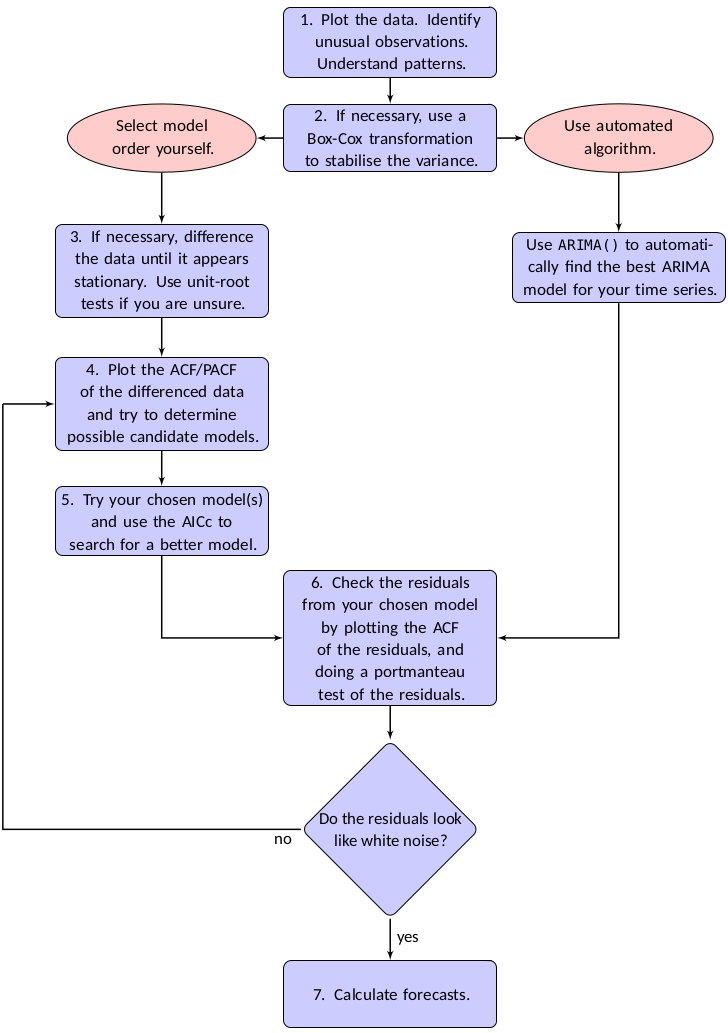



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

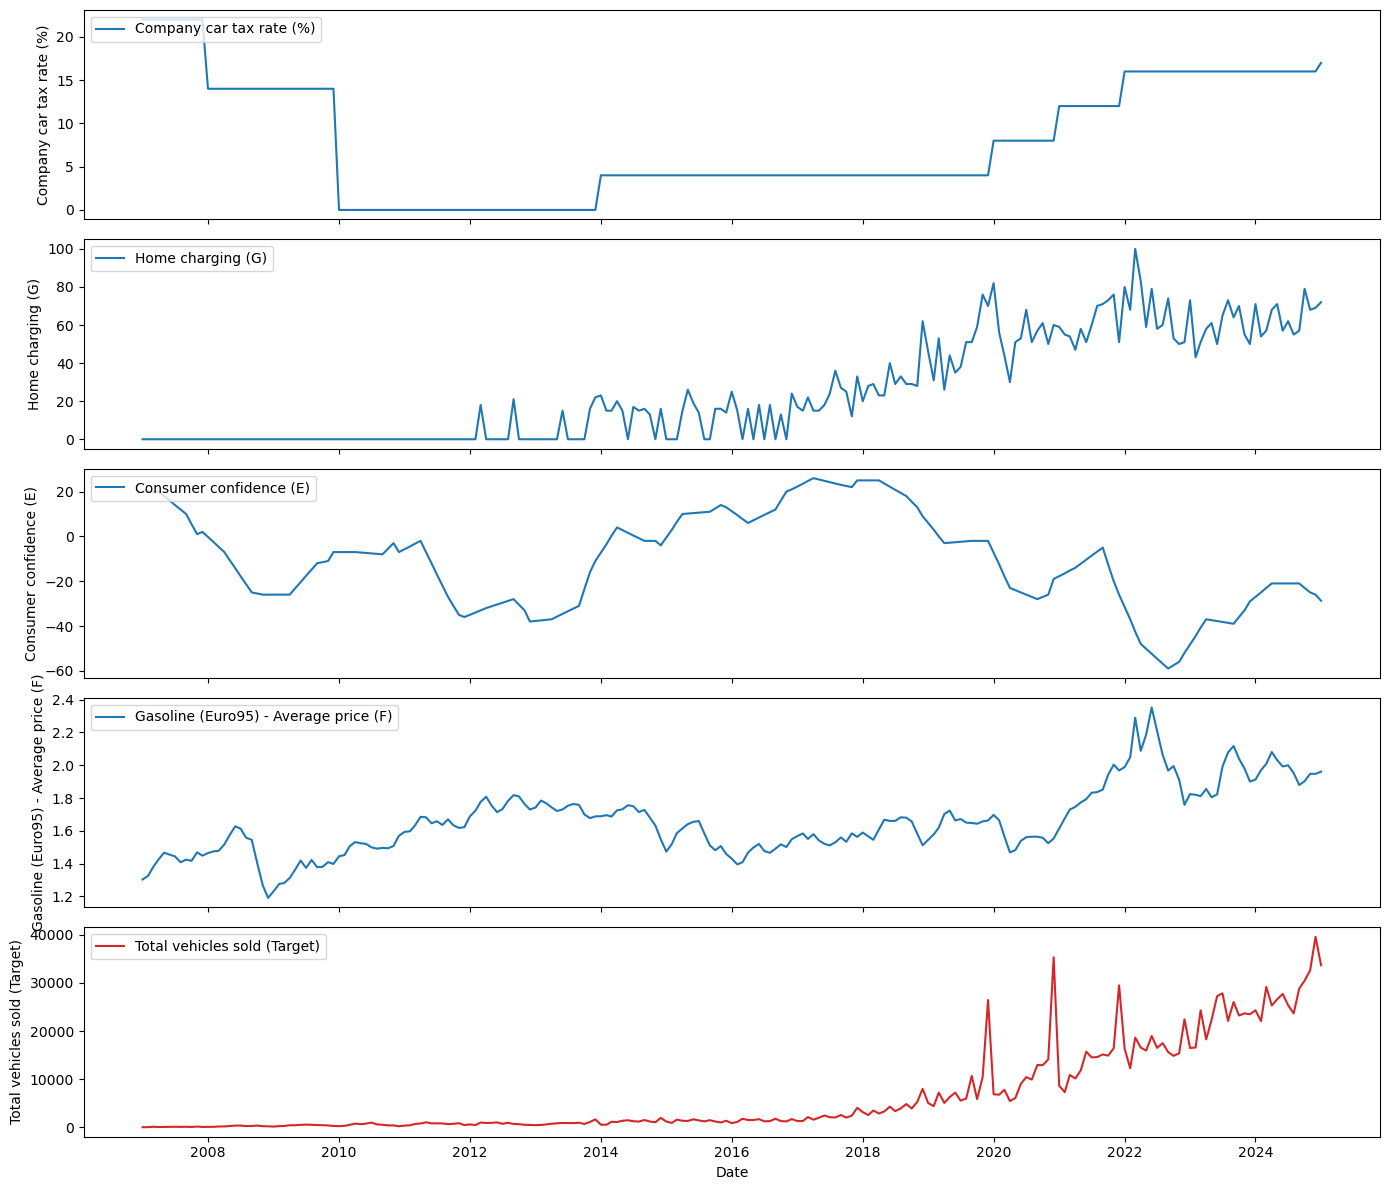

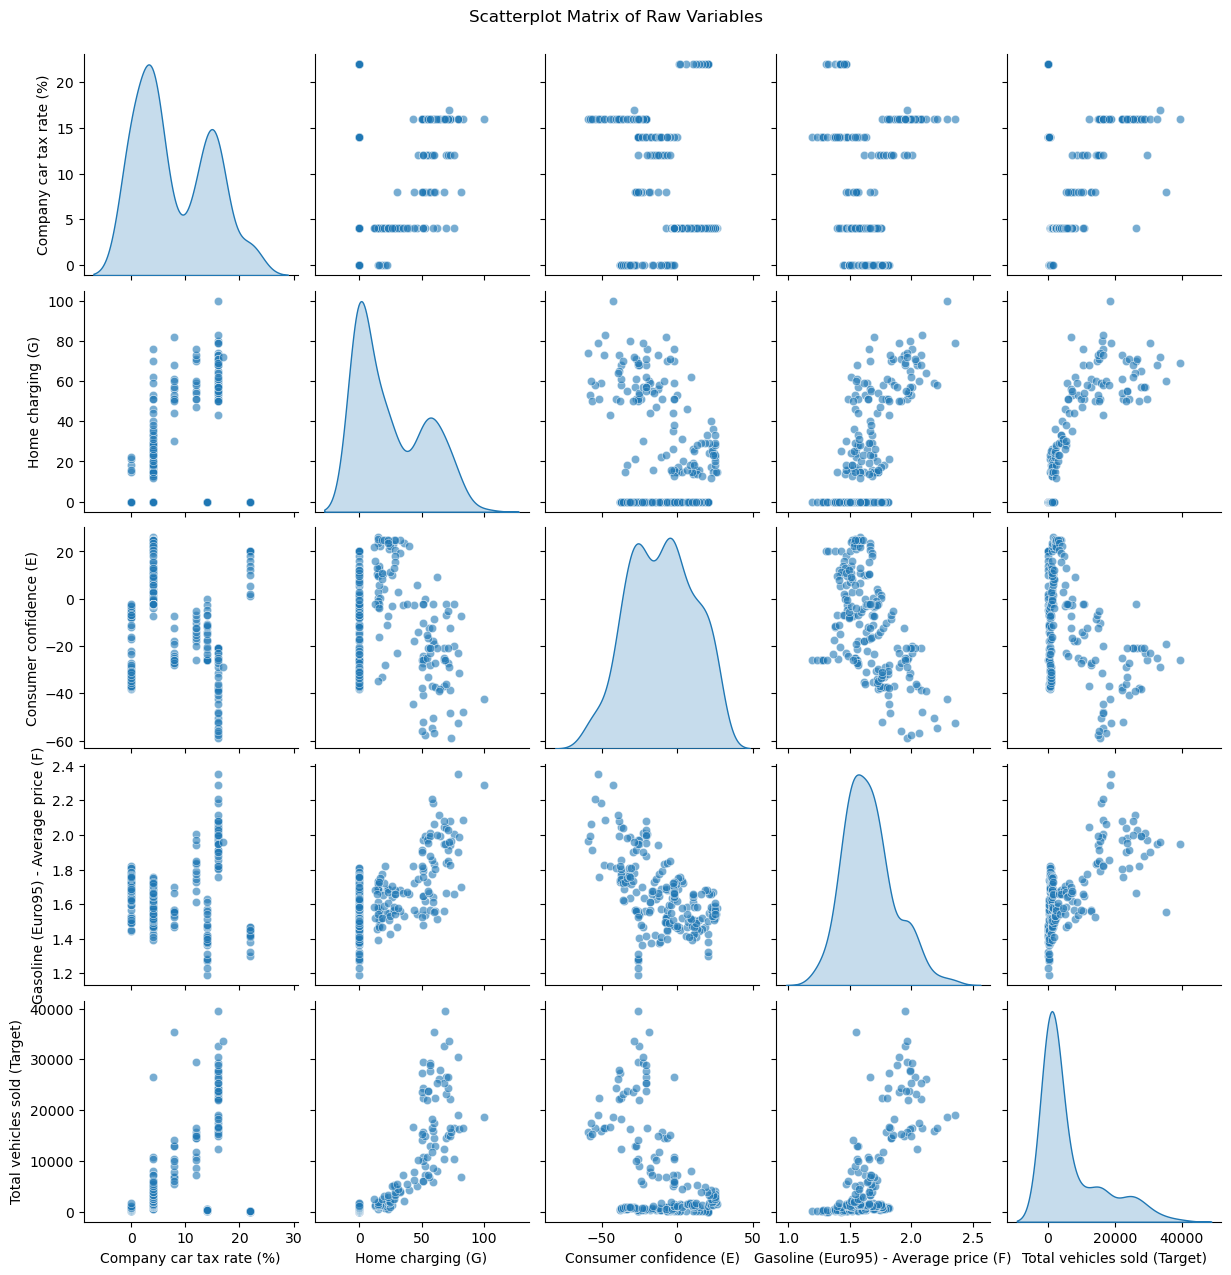

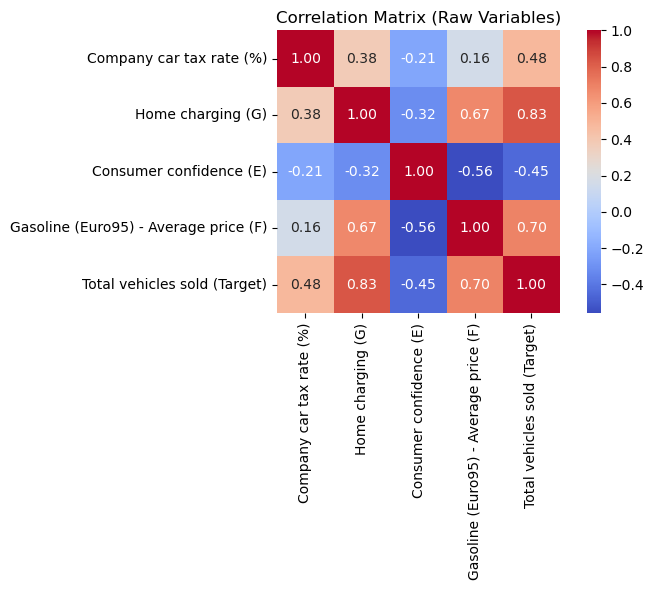

In [3]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Scatterplot matrix (pairplot) for all features and target
sns.pairplot(df[features + [target]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables", y=1.02)
plt.show()

# Correlation matrix for all features and target
corr_matrix = df[features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()


## Observations first plots 

> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4. Data Split & Transformations

## 4a Apply train/val/test split

In [4]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")




Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


#### Deze plot zou ook weggelaten kunnen worden 

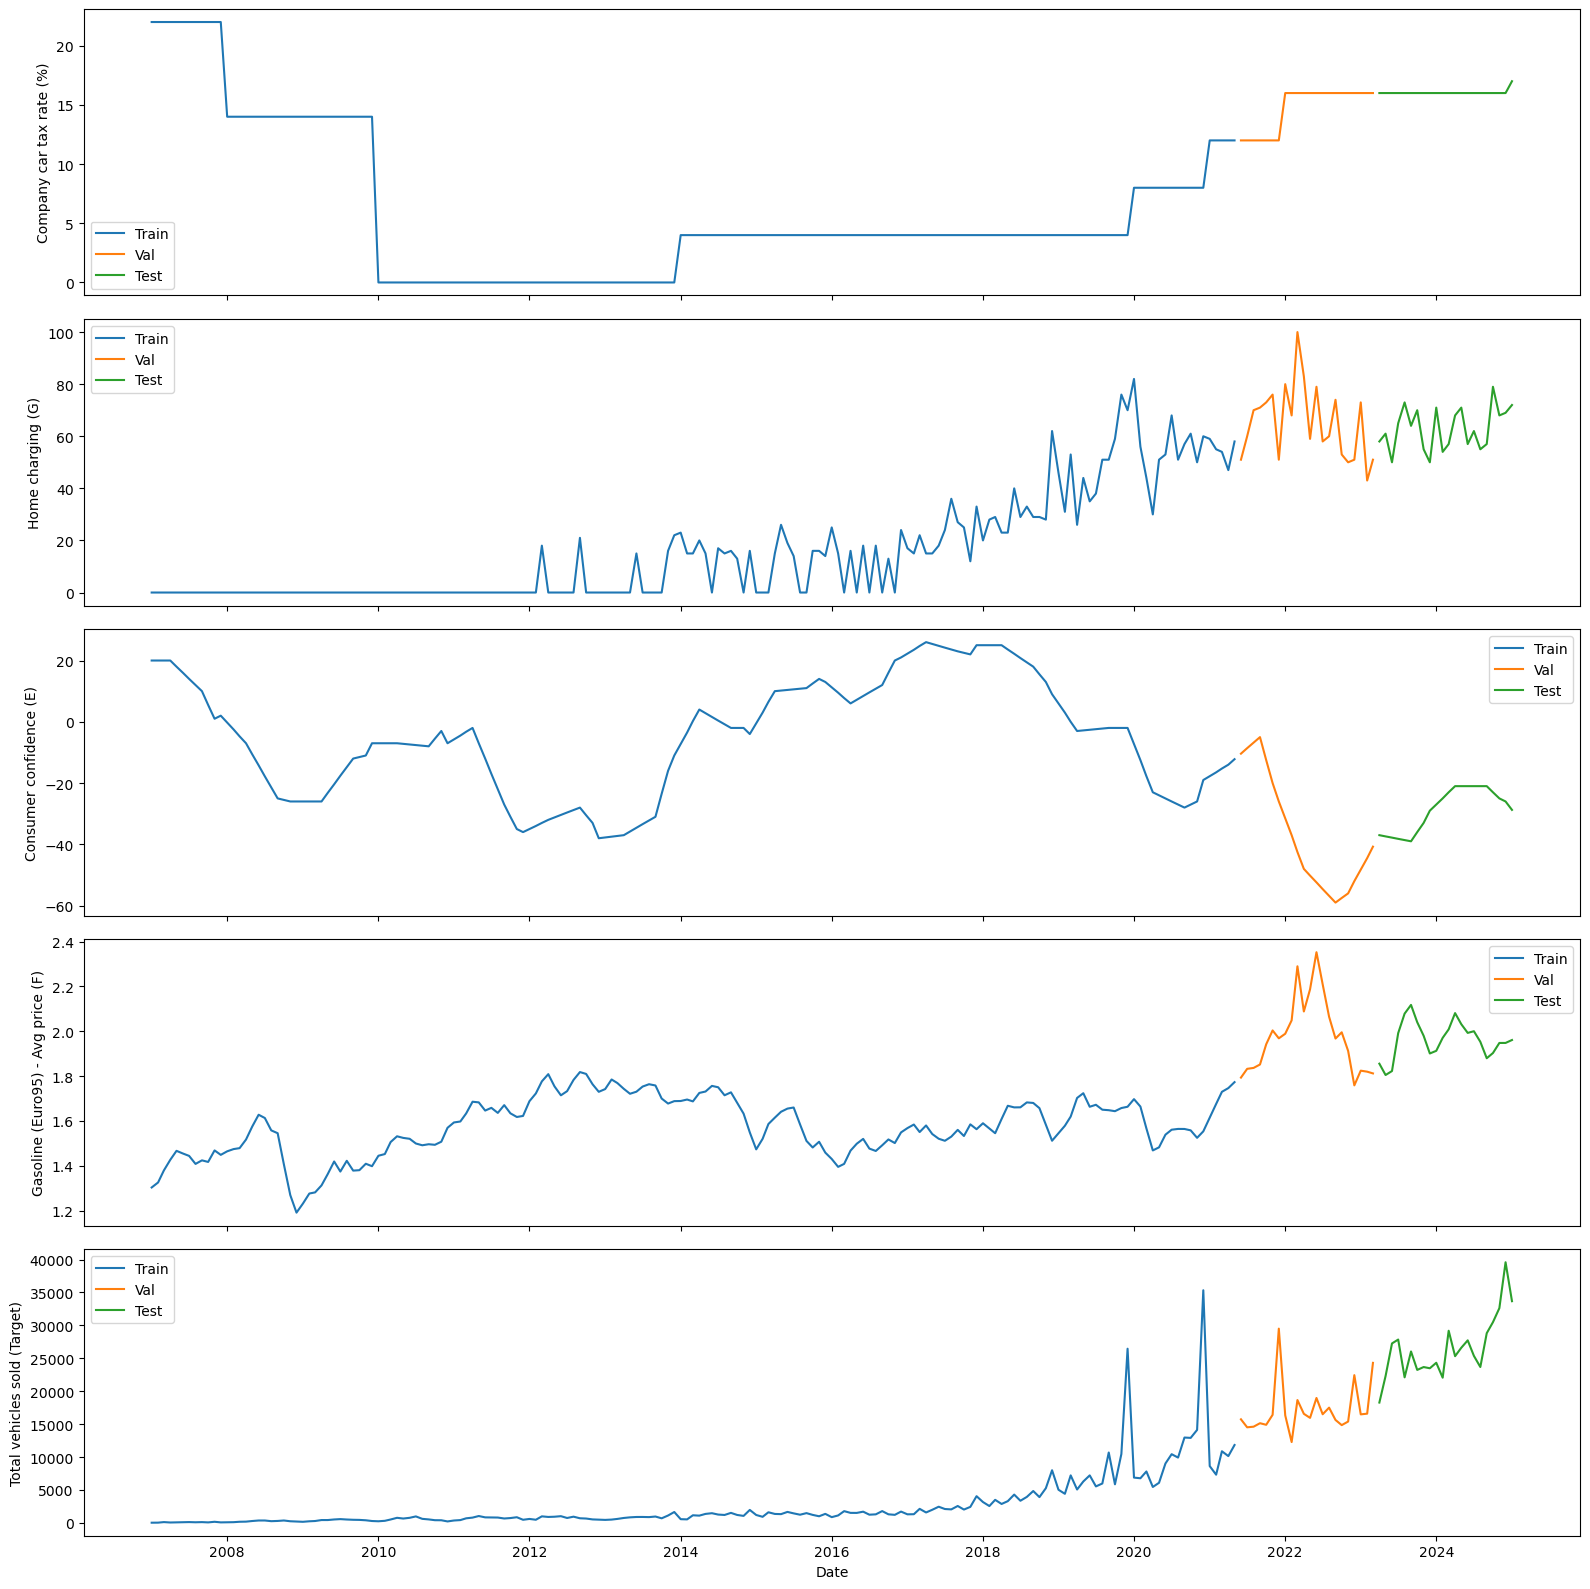

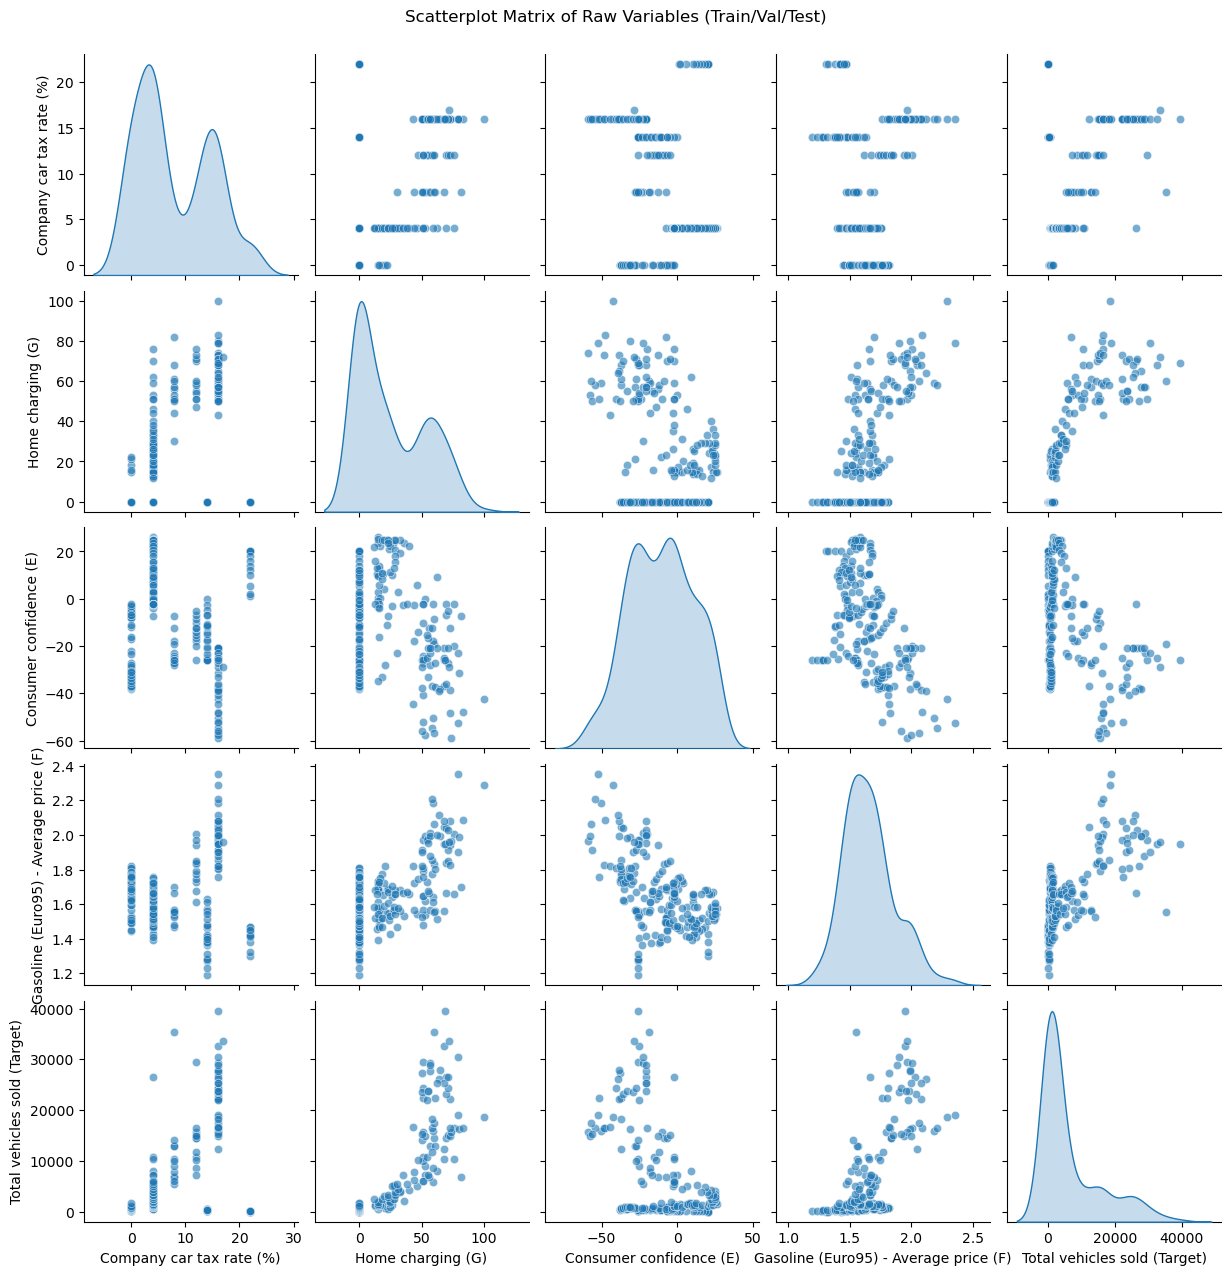

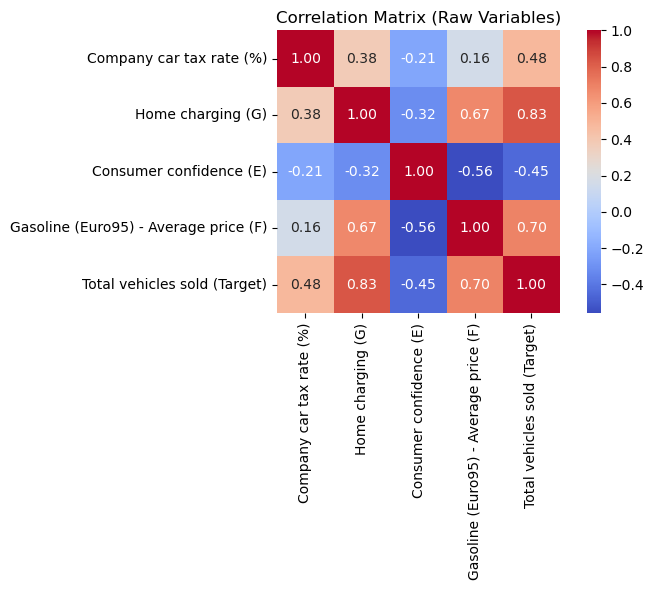

=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===
Company car tax rate (%)
  ADF: stat=-2.418, p=0.137 | Non-stationary
  KPSS: stat=0.584, p=0.0241 | Non-stationary

Home charging (G)
  ADF: stat=0.083, p=0.965 | Non-stationary
  KPSS: stat=1.618, p=0.01 | Non-stationary

Consumer confidence (E)
  ADF: stat=-2.337, p=0.16 | Non-stationary
  KPSS: stat=0.328, p=0.1 | Stationary

Gasoline (Euro95) - Average price (F)
  ADF: stat=-3.250, p=0.0173 | Stationary
  KPSS: stat=0.507, p=0.04 | Non-stationary

Total vehicles sold (Target)
  ADF: stat=6.289, p=1 | Non-stationary
  KPSS: stat=1.296, p=0.01 | Non-stationary



C:\Users\dylan\AppData\Local\Temp\ipykernel_372\3235616425.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_372\3235616425.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_372\3235616425.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")


In [5]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()

# --- Unit root (ADF/KPSS) and variance instability plots for raw splits ---


def adf_kpss_summary(series, name):
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag='AIC', maxlag=12, regression='c', store=False)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
    print(f"\033[1m{name}\033[0m")
    print(f"  ADF: stat={adf_stat:.3f}, p={adf_p:.3g} | {'Stationary' if adf_p < 0.05 else 'Non-stationary'}")
    print(f"  KPSS: stat={kpss_stat:.3f}, p={kpss_p:.3g} | {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")
    print()

print("=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===")
for col, train_split in zip(features_raw + [target_raw],
                            [companytax_train_raw, homechg_train_raw, conf_train_raw, gas_train_raw, y_train_raw]):
    adf_kpss_summary(train_split, col)



> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

In [6]:
# 1. Fit Yeo–Johnson on train and transform all
from sklearn.preprocessing import PowerTransformer  # Import PowerTransformer for Yeo–Johnson transformation

features_yj = features_raw.copy()  # Copy the list of raw feature names for transformation
target_yj   = target_raw           # Set the target variable name for transformation

yeojohnson_all      = {}           # Dictionary to store transformed values for each column
yeojohnson_lambdas_all = {}        # Dictionary to store the lambda parameter for each column

for col in features_yj + [target_yj]:  # Loop through all features and the target
    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)  # Get training data for the column and reshape for transformer
    pt = PowerTransformer(method='yeo-johnson', standardize=False) # Create transformer (no standardization)
    pt.fit(train_series)                                           # Fit transformer on training data only
    yeojohnson_lambdas_all[col] = pt.lambdas_[0]                   # Store the learned lambda for this column

    full_series = df[col].values.reshape(-1, 1)                    # Get the full column data for transformation
    yeojohnson_all[col] = pt.transform(full_series).flatten()      # Transform the full data and flatten to 1D

# 2. Build transformed DataFrame WITH _yj SUFFIX
#    and update our feature/target name lists accordingly
rename_map = {col: f"{col}_yj" for col in features_yj + [target_yj]}  # Map original names to new names with _yj suffix

yj_df = pd.DataFrame({                                                   
    rename_map[col]: yeojohnson_all[col]                                 # Build DataFrame with transformed columns and new names
    for col in features_yj + [target_yj]
})

# now our new column names:
features_yj = [rename_map[col] for col in features_yj]   # Update features_yj to use new column names with _yj
target_yj   = rename_map[target_yj]                      # Update target_yj to use new column name with _yj

# 3. Define split indices for YJ (same logic as raw)
n_yj         = len(yj_df)                                # Get number of rows in transformed DataFrame
train_end_yj = int(n_yj * 0.8)                           # Compute train split index (80%)
val_end_yj   = int(n_yj * 0.9)                           # Compute validation split index (90%)
test_end_yj  = n_yj                                      # Test split goes to end

# 4. Split Yeo–Johnson–transformed data
y_train_yj = yj_df[target_yj].iloc[:train_end_yj]        # Training split for target
y_val_yj   = yj_df[target_yj].iloc[train_end_yj:val_end_yj]  # Validation split for target
y_test_yj  = yj_df[target_yj].iloc[val_end_yj:]          # Test split for target

companytax_train_yj = yj_df[f"Company car tax rate (%)_yj"].iloc[:train_end_yj]      # Training split for company car tax rate
companytax_val_yj   = yj_df[f"Company car tax rate (%)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
companytax_test_yj  = yj_df[f"Company car tax rate (%)_yj"].iloc[val_end_yj:]        # Test split

homechg_train_yj = yj_df[f"Home charging (G)_yj"].iloc[:train_end_yj]                # Training split for home charging
homechg_val_yj   = yj_df[f"Home charging (G)_yj"].iloc[train_end_yj:val_end_yj]      # Validation split
homechg_test_yj  = yj_df[f"Home charging (G)_yj"].iloc[val_end_yj:]                  # Test split

conf_train_yj = yj_df[f"Consumer confidence (E)_yj"].iloc[:train_end_yj]             # Training split for consumer confidence
conf_val_yj   = yj_df[f"Consumer confidence (E)_yj"].iloc[train_end_yj:val_end_yj]   # Validation split
conf_test_yj  = yj_df[f"Consumer confidence (E)_yj"].iloc[val_end_yj:]               # Test split

gas_train_yj = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[:train_end_yj]    # Training split for gasoline price
gas_val_yj   = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
gas_test_yj  = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[val_end_yj:]      # Test split

# Print split info for YJ
print(f"YJ Train: {train_end_yj} rows | {train_end_yj/n_yj:.1%} of data")                # Print number and percent of train rows
print(f"YJ Val:   {val_end_yj-train_end_yj} rows | {(val_end_yj-train_end_yj)/n_yj:.1%} of data")  # Print val rows
print(f"YJ Test:  {test_end_yj-val_end_yj} rows | {(test_end_yj-val_end_yj)/n_yj:.1%} of data")    # Print test rows

for orig_col, lam in yeojohnson_lambdas_all.items():                                     # Loop through each column and its lambda
    print(f"{orig_col:40s}  λ = {lam:.4f}")                                              # Print the lambda for each column


YJ Train: 173 rows | 79.7% of data
YJ Val:   22 rows | 10.1% of data
YJ Test:  22 rows | 10.1% of data
Company car tax rate (%)                  λ = 0.1486
Home charging (G)                         λ = -0.1635
Consumer confidence (E)                   λ = 1.0165
Gasoline (Euro95) - Average price (F)     λ = 3.9445
Total vehicles sold (Target)              λ = -0.0036


Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22

> Kort woordje houden over de Yeo–Johnson transformation:

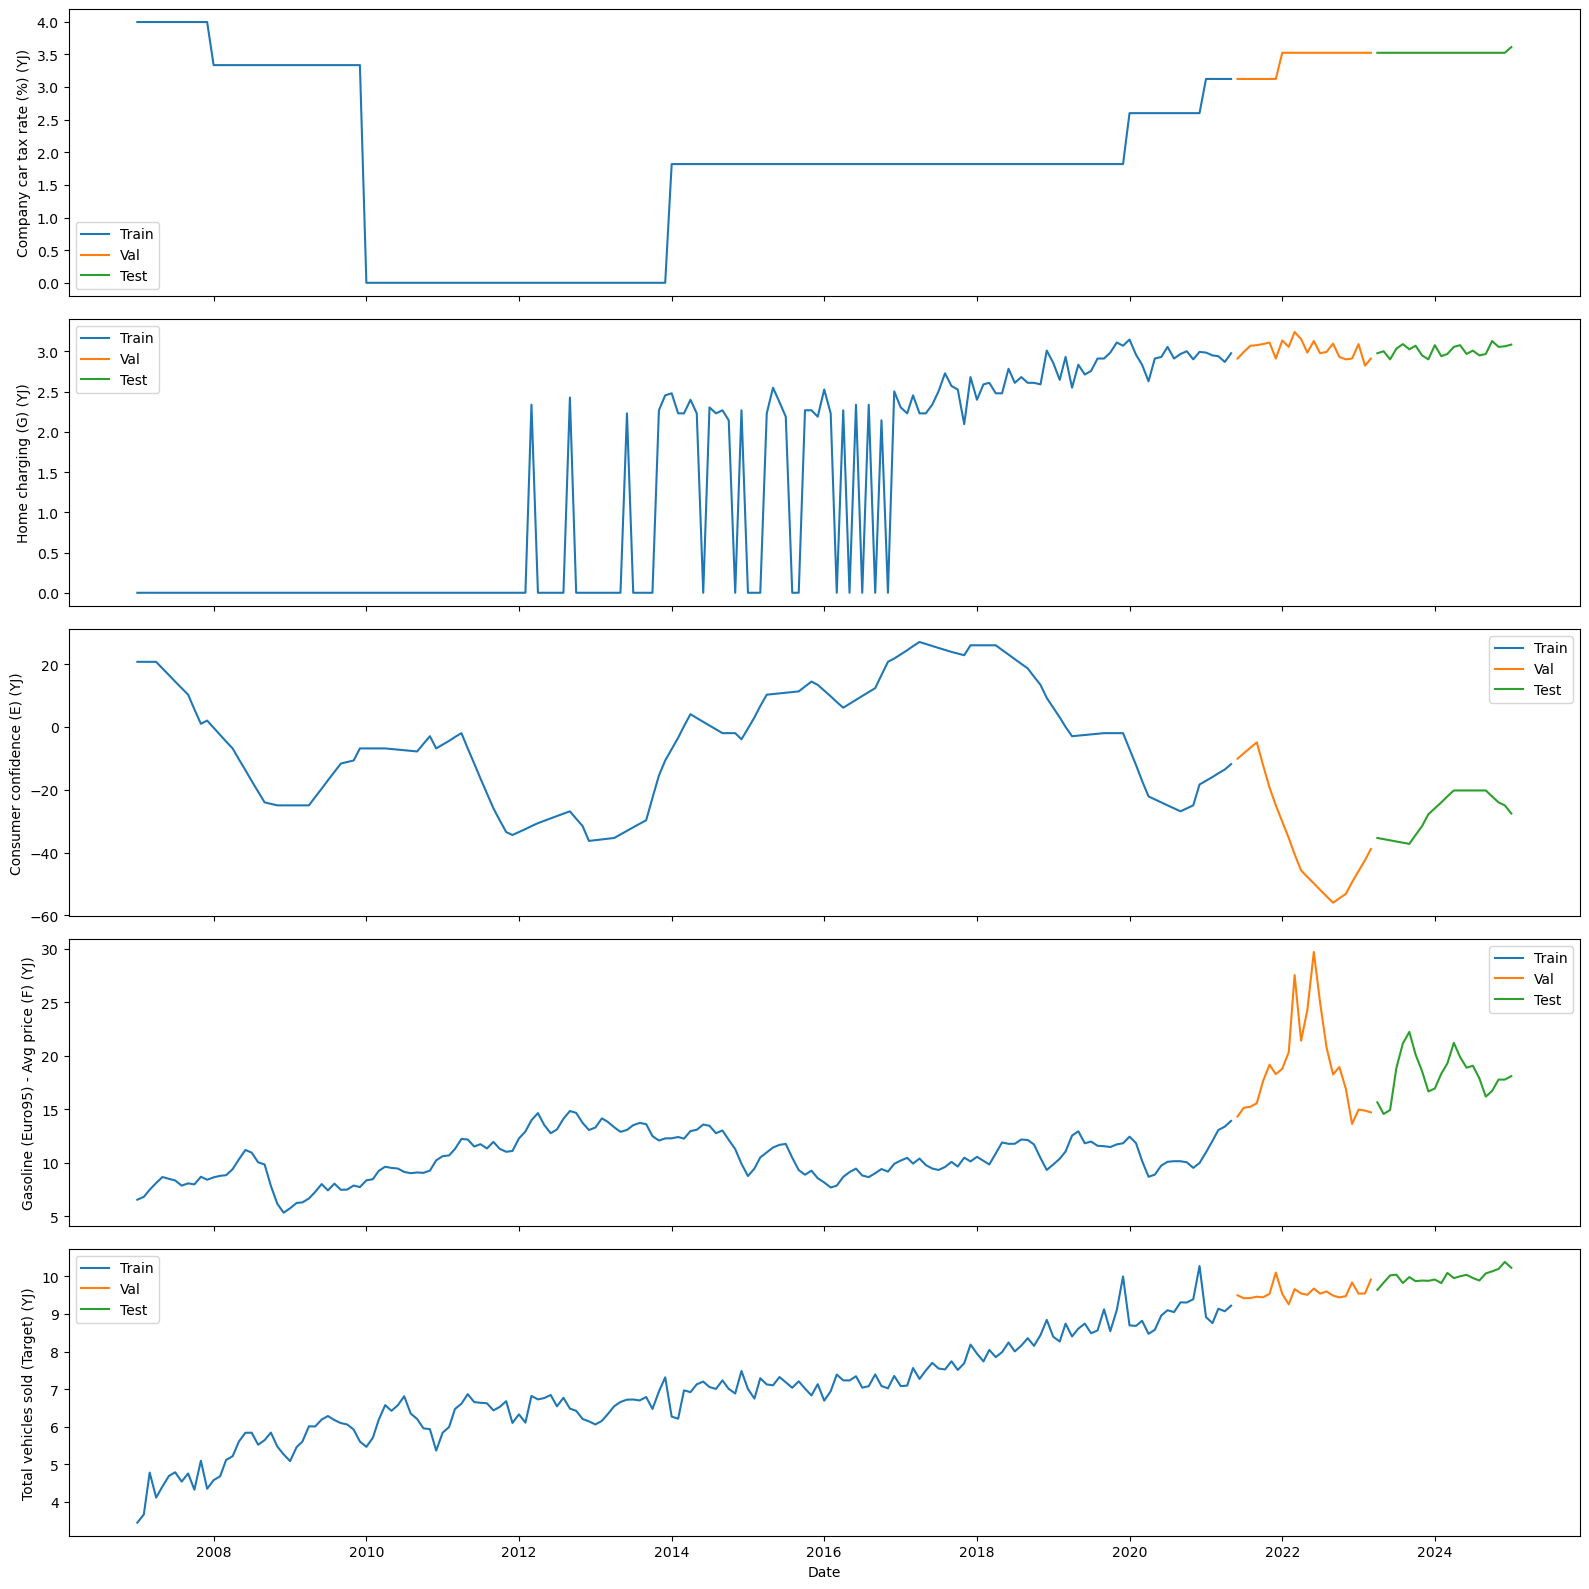

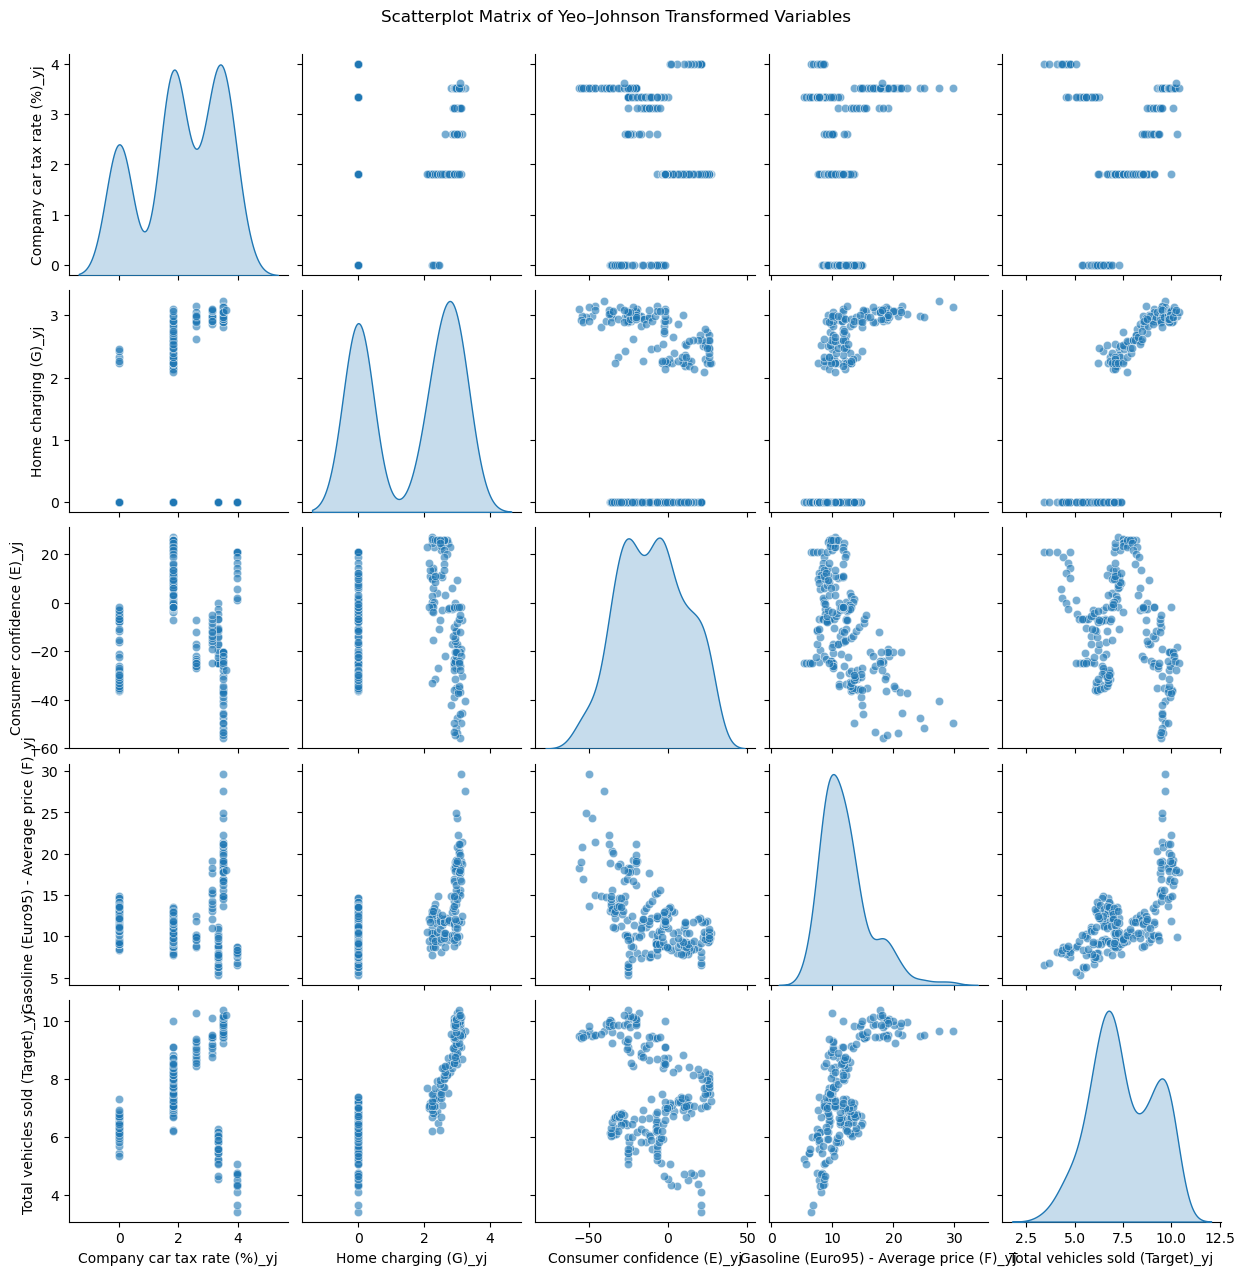

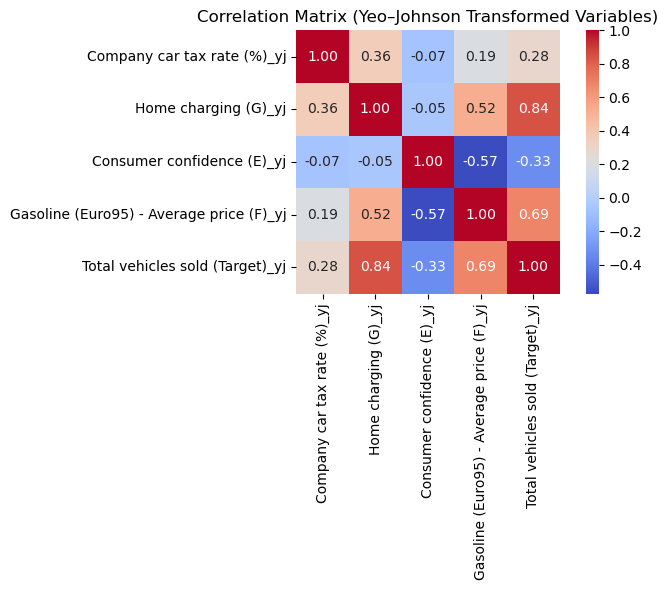

In [7]:
# --- Yeo–Johnson Transformed Train/Val/Test Splits: Time Series Plots ---

fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)_yj
axs[0].plot(time_index.iloc[:train_end_yj], companytax_train_yj, label='Train')
axs[0].plot(time_index.iloc[train_end_yj:val_end_yj], companytax_val_yj, label='Val')
axs[0].plot(time_index.iloc[val_end_yj:], companytax_test_yj, label='Test')
axs[0].set_ylabel('Company car tax rate (%) (YJ)')
axs[0].legend()

# 2. Home charging (G)_yj
axs[1].plot(time_index.iloc[:train_end_yj], homechg_train_yj, label='Train')
axs[1].plot(time_index.iloc[train_end_yj:val_end_yj], homechg_val_yj, label='Val')
axs[1].plot(time_index.iloc[val_end_yj:], homechg_test_yj, label='Test')
axs[1].set_ylabel('Home charging (G) (YJ)')
axs[1].legend()

# 3. Consumer confidence (E)_yj
axs[2].plot(time_index.iloc[:train_end_yj], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_yj:val_end_yj], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_yj:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E) (YJ)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)_yj
axs[3].plot(time_index.iloc[:train_end_yj], gas_train_yj, label='Train')
axs[3].plot(time_index.iloc[train_end_yj:val_end_yj], gas_val_yj, label='Val')
axs[3].plot(time_index.iloc[val_end_yj:], gas_test_yj, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F) (YJ)')
axs[3].legend()

# 5. Total vehicles sold (Target)_yj
axs[4].plot(time_index.iloc[:train_end_yj], y_train_yj, label='Train')
axs[4].plot(time_index.iloc[train_end_yj:val_end_yj], y_val_yj, label='Val')
axs[4].plot(time_index.iloc[val_end_yj:], y_test_yj, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target) (YJ)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) for Yeo–Johnson transformed features + target ---
sns.pairplot(yj_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlation matrix ---
corr_matrix_yj = yj_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_yj, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()

The Yeo–Johnson code fits the transformer only on the training subset, then applies those learned parameters to the full series. That approach does not leak information from validation or test sets back into the model.

## 4c Stationarity Tests

After plotting and splitting the data its time for staionality tests. 

Since Arima models rely on past autocorrelations to make predictions, they assume stationality in the data.

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. observing the previous plots, we can see non stationality in the data by some upward trends and seasonality. 

Visually, stationary series tend to look flat and horizontal, possibly with random fluctuations or irregular cycles, but without consistent upward/downward trends or recurring patterns.

There are a few tests to check for stationarity, the most common ones are:
- **Augmented Dickey-Fuller (ADF) test**: Tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. A low p-value (typically < 0.05) suggests that the series is stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: Tests the null hypothesis that a time series is stationary around a deterministic trend. A high p-value (typically > 0.05) suggests stationarity.
plotting the ACF and PACF plots can also help to identify stationarity.

ADF focuses on detecting a unit root (non-stationarity) under the null hypothesis.

KPSS assumes stationarity under the null hypothesis.
because 




> verklein tot 2 tabellen 1 voor differencing laat zien welke features stationary zijn (of niet) vervolgens wordt fitst differencing toegepast en weer zelfde tabel geprint. hierin kan dus aangetoon worden dat differencing waarschijnlijk nodig is voor het optimale model. 


In [8]:
import pandas as pd

def stationarity_summary(series, col_name):
    adf_res = adfuller(series, autolag='AIC')
    kpss_res = kpss(series, regression='ct', nlags='legacy')
    
    return {
        'Series'            : col_name,
        'ADF Stat / p'      : (adf_res[0], adf_res[1]),
        'ADF Criticals'     : adf_res[4],
        'KPSS Stat / p'     : (kpss_res[0], kpss_res[1]),
        'KPSS Criticals'    : kpss_res[3],
        'ADF Stationary'    : adf_res[1] < 0.05,
        'KPSS Stationary'   : kpss_res[1] >= 0.05
    }
# Example usage: run stationarity tests on all Yeo–Johnson transformed features and target (train split)
stationarity_results = []
for col in features_yj + [target_yj]:
    train_series = yj_df[col].iloc[:train_end_yj].values
    result = stationarity_summary(train_series, col)
    stationarity_results.append(result)

# Display summary table
summary_df = pd.DataFrame(stationarity_results)
print(summary_df[['Series', 'ADF Stat / p', 'ADF Stationary', 'KPSS Stat / p', 'KPSS Stationary']])

                                     Series  \
0               Company car tax rate (%)_yj   
1                      Home charging (G)_yj   
2                Consumer confidence (E)_yj   
3  Gasoline (Euro95) - Average price (F)_yj   
4           Total vehicles sold (Target)_yj   

                                 ADF Stat / p  ADF Stationary  \
0   (-1.8590337625259836, 0.3515713706401373)           False   
1   (-0.3142477652488584, 0.9234620419667042)           False   
2  (-2.3179308476205174, 0.16625011245897198)           False   
3    (-2.211018285949689, 0.2022707868264217)           False   
4  (-0.27954103369173594, 0.9283523684229519)           False   

                                 KPSS Stat / p  KPSS Stationary  
0                  (0.22589780667744153, 0.01)            False  
1    (0.15133965546450295, 0.0455502871129142)            False  
2   (0.13281951252772778, 0.07440831013383743)             True  
3  (0.16640766291385184, 0.032993614238456793)            Fals

C:\Users\dylan\AppData\Local\Temp\ipykernel_372\2896556714.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series, regression='ct', nlags='legacy')


In [9]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj = {}

for col in features_yj + [target_yj]:
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values

    adf_result = adfuller(train_yj)
    kpss_result = kpss(train_yj, regression='c', nlags="auto")

    results_yj[col] = {
        "ADF stat": adf_result[0],
        "ADF p-value": adf_result[1],
        "KPSS stat": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

# Print overall verdict for each variable
for col, res in results_yj.items():
    print(f"\n==== {col} ====")
    print(f"ADF stat: {res['ADF stat']:.4f} | p-value: {res['ADF p-value']:.4f} | {'Stationary' if res['ADF Stationary'] else 'Non-stationary'} (ADF)")
    print(f"KPSS stat: {res['KPSS stat']:.4f} | p-value: {res['KPSS p-value']:.4f} | {'Stationary' if res['KPSS Stationary'] else 'Non-stationary'} (KPSS)")

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj.values())
if all_stationary:
    print("\nAll series are stationary according to both ADF and KPSS.")
else:
    print("\nSome series are non-stationary according to ADF or KPSS. Consider differencing.")


==== Company car tax rate (%)_yj ====
ADF stat: -1.8590 | p-value: 0.3516 | Non-stationary (ADF)
KPSS stat: 0.3410 | p-value: 0.1000 | Stationary (KPSS)

==== Home charging (G)_yj ====
ADF stat: -0.3142 | p-value: 0.9235 | Non-stationary (ADF)
KPSS stat: 1.8622 | p-value: 0.0100 | Non-stationary (KPSS)

==== Consumer confidence (E)_yj ====
ADF stat: -2.3179 | p-value: 0.1663 | Non-stationary (ADF)
KPSS stat: 0.3320 | p-value: 0.1000 | Stationary (KPSS)

==== Gasoline (Euro95) - Average price (F)_yj ====
ADF stat: -2.2110 | p-value: 0.2023 | Non-stationary (ADF)
KPSS stat: 0.4606 | p-value: 0.0510 | Stationary (KPSS)

==== Total vehicles sold (Target)_yj ====
ADF stat: -0.2795 | p-value: 0.9284 | Non-stationary (ADF)
KPSS stat: 1.8858 | p-value: 0.0100 | Non-stationary (KPSS)

Some series are non-stationary according to ADF or KPSS. Consider differencing.


> Company car tax rate (%):
Final Verdict on Differencing
Based on the Yeo–Johnson transform, STL decomposition and the mixed ADF/KPSS signals, you do not need an extra first difference. Here’s why:

The STL trend (orange dashed) captures the underlying drift.

The STL seasonal (green dotted) isolates periodic swings.

The remainder (train – trend – season) looks stationary by eye, and re‐testing that residual would almost certainly confirm it.

Next steps

Work with the STL remainder as your stationary series (no further differencing).

When fitting ARIMA/ETS, set

d = 0 (no differencing)

D = 0 (seasonality already removed)

For forecasts, add back:

the STL trend projection

the seasonal pattern

> Final Verdict on Differencing Consumer Confidence (E)

Given the mixed ADF/KPSS outcomes and your STL decomposition, there’s no strong case for an extra first difference on the Yeo–Johnson–transformed consumer confidence series. Here’s why:

ADF suggests non-stationarity (p≈0.17), but KPSS sits just below the 10 % cutoff, hinting at stationarity.

The STL trend (orange dashed) captures any drift, while the seasonal component (green dotted) isolates regular cycles.

Inspecting the STL remainder (data – trend – season) shows no obvious drift or unit-root wiggles.

> Final Verdict on Gasoline (Euro95) – Average Price (F)

The ADF test fails to reject a unit root (p≈0.20), while the KPSS statistic (0.4606) sits just below its 5 % critical value (0.4630), hinting at stationarity. The STL decomposition shows:

the orange dashed line capturing a clear underlying drift

the green dotted line isolating regular seasonal swings

the remainder (data – trend – season) appearing free of obvious trends

Taken together, the evidence again points toward handling trend and seasonality via STL rather than differencing the raw series.

## 4d Apply First/second order differencing

In [10]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj_diff = {}

for col in features_yj + [target_yj]:
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values
    train_yj_diff = np.diff(train_yj, n=1)  # First difference

    adf_result = adfuller(train_yj_diff)
    kpss_result = kpss(train_yj_diff, regression='c', nlags="auto")

    results_yj_diff[col] = {
        "ADF stat": adf_result[0],
        "ADF p-value": adf_result[1],
        "KPSS stat": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

# Print overall verdict for each variable (on differenced data)
for col, res in results_yj_diff.items():
    print(f"\n==== {col} (1st diff) ====")
    print(f"ADF stat: {res['ADF stat']:.4f} | p-value: {res['ADF p-value']:.4f} | {'Stationary' if res['ADF Stationary'] else 'Non-stationary'} (ADF)")
    print(f"KPSS stat: {res['KPSS stat']:.4f} | p-value: {res['KPSS p-value']:.4f} | {'Stationary' if res['KPSS Stationary'] else 'Non-stationary'} (KPSS)")

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj_diff.values())
if all_stationary:
    print("\nAll differenced series are stationary according to both ADF and KPSS.")
else:
    print("\nSome differenced series are still non-stationary according to ADF or KPSS.")

import matplotlib.pyplot as plt




==== Company car tax rate (%)_yj (1st diff) ====
ADF stat: -13.0037 | p-value: 0.0000 | Stationary (ADF)
KPSS stat: 0.3118 | p-value: 0.1000 | Stationary (KPSS)

==== Home charging (G)_yj (1st diff) ====
ADF stat: -5.6151 | p-value: 0.0000 | Stationary (ADF)
KPSS stat: 0.0964 | p-value: 0.1000 | Stationary (KPSS)

==== Consumer confidence (E)_yj (1st diff) ====
ADF stat: -5.3397 | p-value: 0.0000 | Stationary (ADF)
KPSS stat: 0.1481 | p-value: 0.1000 | Stationary (KPSS)

==== Gasoline (Euro95) - Average price (F)_yj (1st diff) ====
ADF stat: -8.4230 | p-value: 0.0000 | Stationary (ADF)
KPSS stat: 0.0548 | p-value: 0.1000 | Stationary (KPSS)

==== Total vehicles sold (Target)_yj (1st diff) ====
ADF stat: -3.4815 | p-value: 0.0085 | Stationary (ADF)
KPSS stat: 0.0694 | p-value: 0.1000 | Stationary (KPSS)

All differenced series are stationary according to both ADF and KPSS.


> give a quick evaluation of the differencing results

In [11]:
#--- OLD code -##

# import warnings
# from statsmodels.tsa.stattools import adfuller, kpss
# import numpy as np

# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# results_yj_diff = {}

# for col in features_yj + [target_yj]:
#     train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
#     train_yj = train_yj.astype(float).values
#     train_yj_diff = np.diff(train_yj, n=1)  # First difference

#     adf_result = adfuller(train_yj_diff)
#     kpss_result = kpss(train_yj_diff, regression='c', nlags="auto")

#     results_yj_diff[col] = {
#         "ADF p-value": adf_result[1],
#         "KPSS p-value": kpss_result[1],
#         "ADF Stationary": adf_result[1] < 0.05,
#         "KPSS Stationary": kpss_result[1] >= 0.05
#     }



# # Print overall verdict for each variable (on differenced data)
# for col, res in results_yj_diff.items():
#     print(f"\n==== {col} (1st diff) ====")
#     print(f"ADF p-value: {res['ADF p-value']:.10f} | {'Stationary' if res['ADF Stationary'] else 'Non-stationary'} (ADF)")
#     print(f"KPSS p-value: {res['KPSS p-value']:.10f} | {'Stationary' if res['KPSS Stationary'] else 'Non-stationary'} (KPSS)")

# # Optional: quick overall verdict
# all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj_diff.values())
# if all_stationary:
#     print("\nAll differenced series are stationary according to both ADF and KPSS.")
# else:
#     print("\nSome differenced series are still non-stationary according to ADF or KPSS.")

# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


> Beargumenteer waar om benchamrk op raw data is geplot en niet op de transfomeerde data 

✅ Yes, benchmarks can be set on YJ-transformed data.
But for performance metrics like RMSE and MAPE, you should:

⚠️ Always inverse-transform the forecasts back to the original (raw) scale before calculating those metrics.

Naïve 3-step RMSE (original): 5360.99
Naïve 3-step MAPE (original): 19.05%
Seasonal Naïve 3-step RMSE (original): 4456.62
Seasonal Naïve 3-step MAPE (original): 21.24%
Drift 3-step RMSE (original): 4923.98
Drift 3-step MAPE (original): 20.04%


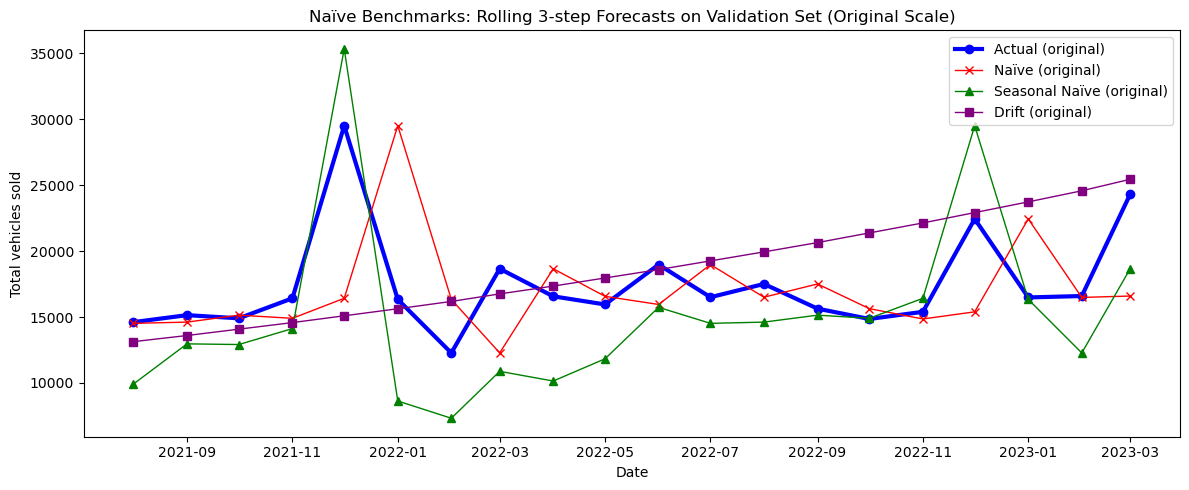

In [12]:
# --- Naive benchmarks on Yeo–Johnson transformed target (validation set) ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

horizon = 3  # Forecast horizon: number of steps ahead to predict

# Use Yeo–Johnson transformed splits
y_all_yj = np.concatenate([y_train_yj.values, y_val_yj.values])  # Full YJ series for rolling forecast (train + val)
y_val_full_yj = y_val_yj.values
y_train_full_yj = y_train_yj.values

# === 1. Naïve Forecast (YJ) ===
naive_preds_yj = []
for t in range(len(y_val_full_yj) - horizon + 1):
    last_obs = y_all_yj[train_end_yj + t + horizon - 2]
    naive_preds_yj.append(last_obs)
naive_preds_yj = np.array(naive_preds_yj)
naive_actuals_yj = y_val_full_yj[horizon-1:]

naive_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, naive_preds_yj))
naive_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, naive_preds_yj)

# print(f"Naïve 3-step RMSE (YJ): {naive_rmse_yj:.2f}")
# print(f"Naïve 3-step MAPE (YJ): {naive_mape_yj:.2%}")

# === 2. Seasonal Naïve Forecast (YJ, 12 months ago) ===
season_length = 12
seasonal_naive_preds_yj = []
for t in range(len(y_val_full_yj) - horizon + 1):
    idx = train_end_yj + t + horizon - 1
    if idx - season_length >= 0:
        pred = y_all_yj[idx - season_length]
    else:
        pred = y_all_yj[train_end_yj + t + horizon - 2]
    seasonal_naive_preds_yj.append(pred)
seasonal_naive_preds_yj = np.array(seasonal_naive_preds_yj)

seasonal_naive_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, seasonal_naive_preds_yj))
seasonal_naive_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, seasonal_naive_preds_yj)

# print(f"Seasonal Naïve 3-step RMSE (YJ): {seasonal_naive_rmse_yj:.2f}")
# print(f"Seasonal Naïve 3-step MAPE (YJ): {seasonal_naive_mape_yj:.2%}")

# === 3. Drift Forecast (YJ) ===
drift_preds_yj = []
n_train_yj = len(y_train_full_yj)
for t in range(len(y_val_full_yj) - horizon + 1):
    steps = n_train_yj + t + horizon - 1
    drift = y_train_full_yj[-1] + ((steps - (n_train_yj - 1)) * (y_train_full_yj[-1] - y_train_full_yj[0]) / (n_train_yj - 1))
    drift_preds_yj.append(drift)
drift_preds_yj = np.array(drift_preds_yj)
drift_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, drift_preds_yj))
drift_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, drift_preds_yj)

# print(f"Drift 3-step RMSE (YJ): {drift_rmse_yj:.2f}")
# print(f"Drift 3-step MAPE (YJ): {drift_mape_yj:.2%}")

# # === Plot all (YJ) ===
x_dates_yj = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj]
# plt.figure(figsize=(12, 5))
# plt.plot(x_dates_yj, naive_actuals_yj, label='Actual (YJ)', marker='o', color='blue', linewidth=3)
# plt.plot(x_dates_yj, naive_preds_yj, label='Naïve (YJ)', marker='x', color='red', linewidth=1)
# plt.plot(x_dates_yj, seasonal_naive_preds_yj, label='Seasonal Naïve (YJ)', marker='^', color='green', linewidth=1)
# plt.plot(x_dates_yj, drift_preds_yj, label='Drift (YJ)', marker='s', color='purple', linewidth=1)
# plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Yeo–Johnson Transformed)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold (YJ transformed)')
# plt.legend()
# plt.tight_layout()
# plt.show()

# --- Inverse transform forecasts for reporting on original scale ---
lam = yeojohnson_lambdas_all[target_raw]
def inv_yeojohnson(z, lam):
    out = np.zeros_like(z)
    pos = z >= 0
    if np.isclose(lam, 0):
        out[pos] = np.exp(z[pos]) - 1
    elif lam == 2:
        out[pos] = -np.exp(-z[pos])
    else:
        out[pos] = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

# Invert YJ for actuals and predictions
actuals_orig = inv_yeojohnson(naive_actuals_yj, lam)
naive_preds_orig = inv_yeojohnson(naive_preds_yj, lam)
seasonal_naive_preds_orig = inv_yeojohnson(seasonal_naive_preds_yj, lam)
drift_preds_orig = inv_yeojohnson(drift_preds_yj, lam)

# Compute metrics on original scale
naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, naive_preds_orig))
naive_mape_orig = mean_absolute_percentage_error(actuals_orig, naive_preds_orig)
seasonal_naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, seasonal_naive_preds_orig))
seasonal_naive_mape_orig = mean_absolute_percentage_error(actuals_orig, seasonal_naive_preds_orig)
drift_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, drift_preds_orig))
drift_mape_orig = mean_absolute_percentage_error(actuals_orig, drift_preds_orig)

print(f"Naïve 3-step RMSE (original): {naive_rmse_orig:.2f}")
print(f"Naïve 3-step MAPE (original): {naive_mape_orig:.2%}")
print(f"Seasonal Naïve 3-step RMSE (original): {seasonal_naive_rmse_orig:.2f}")
print(f"Seasonal Naïve 3-step MAPE (original): {seasonal_naive_mape_orig:.2%}")
print(f"Drift 3-step RMSE (original): {drift_rmse_orig:.2f}")
print(f"Drift 3-step MAPE (original): {drift_mape_orig:.2%}")

# Plot actuals and forecasts on the original (inverse-transformed) scale
plt.figure(figsize=(12, 5))
plt.plot(x_dates_yj, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_yj, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_yj, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_yj, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


All forecasting is performed in the transformed space.

All error metrics are reported on the inverse-transformed (original) scale for interpretability.

# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

First up auto arima will be used to fit the model for the target value.
Using auto_arima gives  a fast, starting point. It automatically scans a wide range of (p, d, q) and seasonal orders using information criteria (AICc, BIC), so i don’t have to write dozens of loops yourself. This initial model often captures the dominant autocorrelation and differencing structure.

for this seasonal i choose for 3,6 and 12 as seasonal periods, because the data is monthly and has a yearly seasonality.

d will stay on zere since its already defined.

> Since you already applied BoxCox and first differencing to your target, you should:

> Use diff_results[target] as your input to auto_arima.
Set d=0, D=0 in auto_arima (no further differencing).
Use the same target variable name as before (it refers to your column name, e.g., 'Total vehicles sold (Target)'

> Deze ff veranderen zodat BIC EN AIC naast elkaar staan

> overfit nieuw plan is:
1. plot data (check)
2. transform data (check, did YJ)
3. difference data (check)
4. plot acf and pacf of differenced data -> choose candidate model
5. try chosen models and use aicc to search for better model 
6. check residuels from chosen model by plotting acf of the residuels and doing pormanteau test of residuels
7. Do residuals look like white noise? If no plot ACF and check other candidate models.

In [13]:
# import warnings
# import pmdarima as pm
# from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# warnings.filterwarnings("ignore", category=ValueWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# # Your input series (Yeo–Johnson transformed target)
# carsales_target_yj = yj_df[target_yj]

# best_aicc = float("inf")
# best_model = None
# best_order = None
# best_seasonal_order = None
# best_with_intercept = None

# # Step 1: Differencing order d is chosen internally by auto_arima

# # Step 2a: Initial models to fit (for seasonal SARIMA)
# # You can define initial candidates for seasonal orders if you want:
# initial_seasonal_orders = [
#     (0, None, 0, 12),
#     (2, None, 2, 12),
#     (1, None, 0, 12),
#     (0, None, 1, 12)
# ]
# # d will be inferred by auto_arima (pass None)

# print(f"Running Hyndman-Khandakar initial SARIMA fits on {carsales_target_yj.name}...")

# for seasonal_order in initial_seasonal_orders:
#     start_p, _, start_q, m = seasonal_order
#     try:
#         model = pm.auto_arima(
#             y=carsales_target_yj,
#             start_p=start_p,
#             max_p=start_p,
#             start_q=start_q,
#             max_q=start_q,
#             d=None,
#             seasonal=True,
#             start_P=0,
#             max_P=2,
#             start_Q=0,
#             max_Q=2,
#             m=m,
#             stepwise=True,
#             trace=True,
#             error_action="ignore",
#             suppress_warnings=True,
#             with_intercept=True,  # You can change this logic depending on d
#             information_criterion="aicc",
#         )
#         aicc = model.aicc()
#         print(f"Fitted SARIMA{model.order}x{model.seasonal_order} with AICc={aicc:.2f}")
#         if aicc < best_aicc:
#             best_aicc = aicc
#             best_model = model
#             best_order = model.order
#             best_seasonal_order = model.seasonal_order
#             best_with_intercept = True  # Adjust if you want to track intercept status
#     except Exception as e:
#         print(f"Error fitting SARIMA with seasonal_order={seasonal_order}: {e}")

# # Step 2b: Set best model as current

# # Step 2c: Explore variations on p, q, P, Q and intercept
# print("\nStarting stepwise search for improvements...")

# improvement = True
# while improvement:
#     improvement = False

#     p, d, q = best_order
#     P, D, Q, m = best_seasonal_order

#     # Candidate orders for p, q, P, Q (+/-1 within allowed ranges)
#     candidate_orders = []
#     for new_p in [p-1, p, p+1]:
#         if 0 <= new_p <= 5:
#             for new_q in [q-1, q, q+1]:
#                 if 0 <= new_q <= 5:
#                     for new_P in [P-1, P, P+1]:
#                         if 0 <= new_P <= 2:
#                             for new_Q in [Q-1, Q, Q+1]:
#                                 if 0 <= new_Q <= 2:
#                                     candidate_orders.append(
#                                         ((new_p, d, new_q), (new_P, D, new_Q, m))
#                                     )

#     # Try with and without intercept
#     for with_intercept in [True, False]:
#         for order, seasonal_order in candidate_orders:
#             try:
#                 model = pm.auto_arima(
#                     y=carsales_target_yj,
#                     start_p=order[0],
#                     max_p=order[0],
#                     start_q=order[2],
#                     max_q=order[2],
#                     d=order[1],
#                     seasonal=True,
#                     start_P=seasonal_order[0],
#                     max_P=seasonal_order[0],
#                     start_Q=seasonal_order[2],
#                     max_Q=seasonal_order[2],
#                     m=seasonal_order[3],
#                     stepwise=True,
#                     trace=False,
#                     error_action="ignore",
#                     suppress_warnings=True,
#                     with_intercept=with_intercept,
#                     information_criterion="aicc",
#                 )
#                 aicc = model.aicc()
#                 if aicc < best_aicc:
#                     print(f"Improved model: SARIMA{model.order}x{model.seasonal_order} with intercept={with_intercept} AICc={aicc:.2f}")
#                     best_aicc = aicc
#                     best_model = model
#                     best_order = model.order
#                     best_seasonal_order = model.seasonal_order
#                     best_with_intercept = with_intercept
#                     improvement = True
#             except Exception:
#                 continue

# print("\nFinal best model:")
# print(f"Order: {best_order}")
# print(f"Seasonal order: {best_seasonal_order}")
# print(f"With intercept: {best_with_intercept}")
# print(f"AICc: {best_aicc:.2f}")


> Iteration 1 using best AIC model (0, 1, 1)(1, 0, 1, 12)

In [14]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.stats.diagnostic import acorr_ljungbox
# import scipy.stats as stats

# # 1. Set forecast horizon
# horizon = 3  # Number of steps ahead to forecast

# # 2. Grab YJ‐transformed train/val arrays (no manual differencing)
# train_yj = y_train_yj.values  # Yeo-Johnson transformed training data
# val_yj   = y_val_yj.values    # Yeo-Johnson transformed validation data

# # 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
# val_actuals = df[target_raw]\
#     .iloc[train_end_yj + horizon - 1 : val_end_yj]\
#     .values

# # 4. Time‐axis for plotting
# plot_dates = df["Time Period (T)"]\
#     .iloc[train_end_yj + horizon - 1 : val_end_yj]

# # 5. Rolling SARIMAX forecasts (let model handle differencing)
# preds_level   = []
# ci80_lower    = []
# ci80_upper    = []
# ci95_lower    = []
# ci95_upper    = []

# for t in range(len(val_yj) - horizon + 1):
#     history = np.concatenate([train_yj, val_yj[:t]])  # Expanding window

#     model = SARIMAX(
#         history,
#         order=(0, 1, 1),  # Let SARIMAX do the differencing (d=1) using new model 
#         seasonal_order=(0, 1, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     fc = fitted.get_forecast(steps=horizon)
#     yj_forecast_level = fc.predicted_mean[-1]

#     # Invert Yeo–Johnson
#     lam = yeojohnson_lambdas_all[target_raw]
#     def inv_yeojohnson(z, lam):
#         if np.isclose(lam, 0):
#             out[pos] = np.exp(z[pos]) - 1

#         elif lam == 2:
#             return -np.exp(-z)
#         out = np.zeros_like(z)
#         pos = z >= 0
#         out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
#         out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
#         return out

#     preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#     ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
#     ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
#     ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
#     ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
#     ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
#     ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# # 6. Align actuals
# actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)

# # 9. Last fitted model’s AIC/BIC and residual diagnostics
# print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
# print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("ACF of SARIMAX Residuals")

# # Use plot_dates for the x-axis of the residuals time series
# axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
# axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
# axes[0, 1].set_xlabel("Date")
# axes[0, 1].set_ylabel("Residual")
# axes[0, 1].tick_params(axis='x', rotation=45) 

# axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of Residuals")
# stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of Residuals")
# plt.tight_layout()
# plt.show()

# lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box (no autocorrelation if p > 0.05):")
# print(lb[['lb_stat','lb_pvalue']])



# # 8. Plot results
# plt.figure(figsize=(12, 5))
# plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
# plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
# plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
# plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
# plt.title('Best AIC SARIMA (YJ, d=1): Rolling 3-step Forecasts')
# plt.xlabel('Date')
# plt.ylabel(target_raw)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 7. Metrics
# rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
# mape = mean_absolute_percentage_error(actuals_level, preds_level)

# print(f"Validation RMSE (rolling): {rmse:.2f}")
# print(f"Validation MAPE (rolling): {mape:.2%}")

> Ljung-Box Test Summary

lb_stat lb_pvalue 10 24.095668 0.007350 20 35.924779 0.015697 30 48.323444 0.018401

All three p-values are below 0.05, which rejects the null hypothesis of no autocorrelation in the residuals at those lags.

Since the Ljung-Box test yields p < 0.05 at multiple lags,The SARIMAX residuals are not white noise. This means the model still leaves systematic structure (autocorrelation) unexplained. In other words, it’s not yet a “good” fit for the data.

> Iteration 2 best BIC model (0, 1, 1)(1, 0, 0, 12)

AIC (last SARIMAX fit): -17.62
BIC (last SARIMAX fit): -4.91


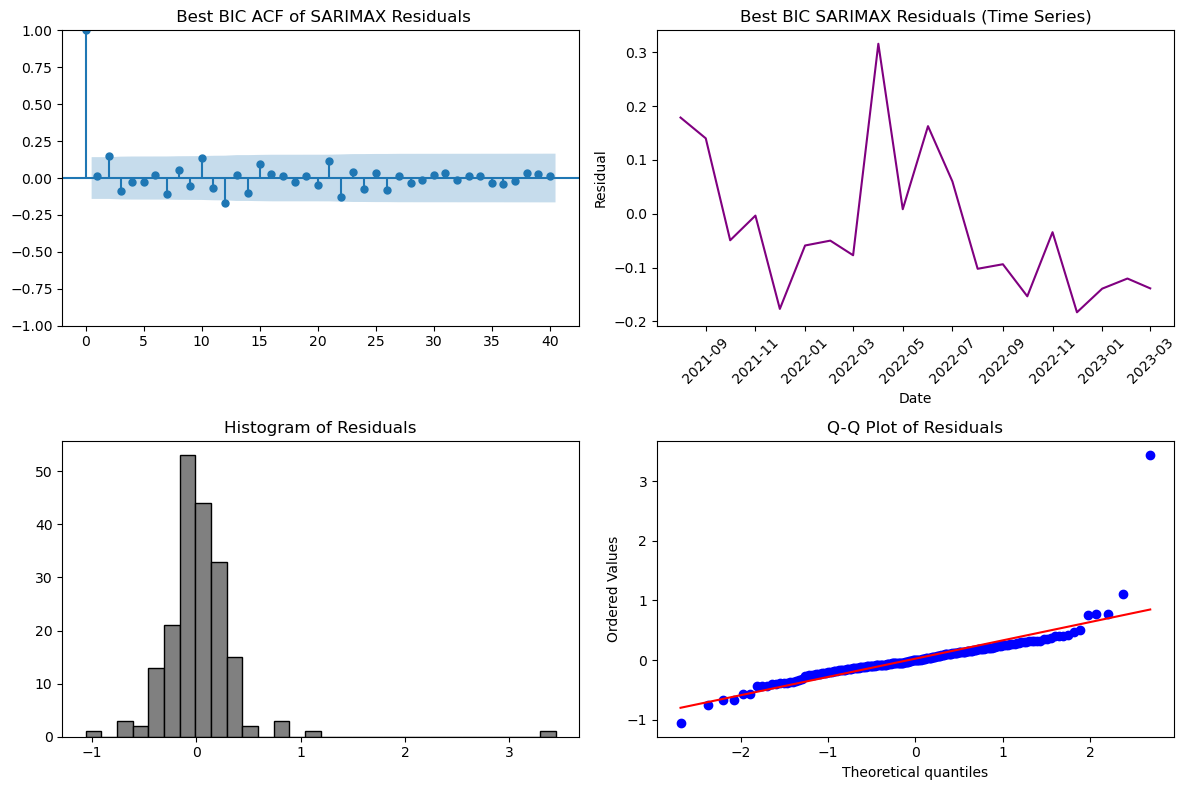

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  13.536943   0.195180
20  25.516706   0.182373
30  36.082990   0.205373


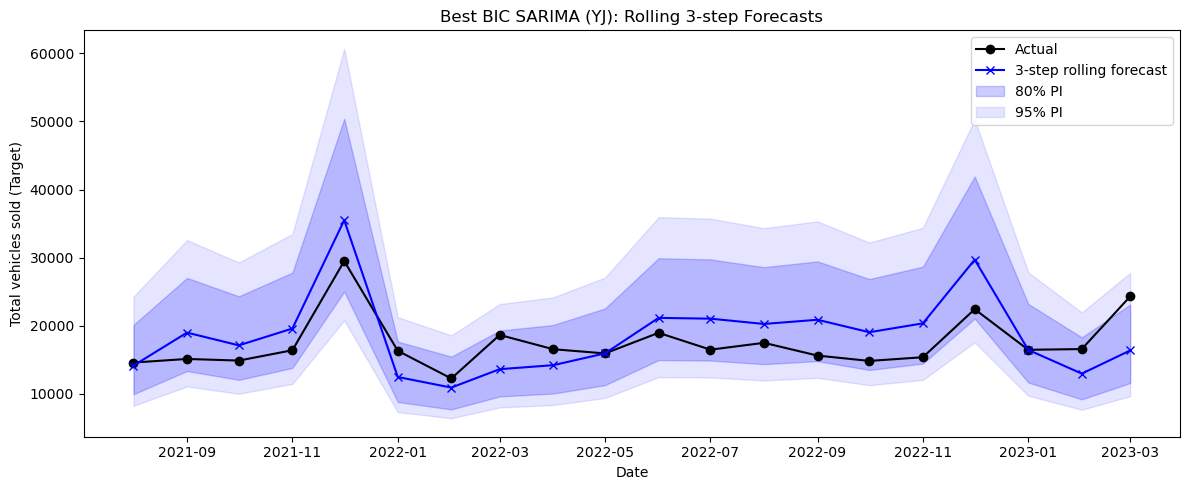

Validation RMSE (rolling): 4155.47
Validation MAPE (rolling): 19.74%


In [15]:

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab YJ‐transformed train/val arrays (no manual differencing)
train_yj = y_train_yj.values  # Yeo-Johnson transformed training data
val_yj   = y_val_yj.values    # Yeo-Johnson transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]\
    .values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

for t in range(len(val_yj) - horizon + 1):
    history = np.concatenate([train_yj, val_yj[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(0, 1, 1),  # Let SARIMAX do the differencing (d=1)
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    yj_forecast_level = fc.predicted_mean[-1]

    # Invert Yeo–Johnson
    lam = yeojohnson_lambdas_all[target_raw]
    def inv_yeojohnson(z, lam):
        if np.isclose(lam, 0):
            out[pos] = np.exp(z[pos]) - 1

        elif lam == 2:
            return -np.exp(-z)
        out = np.zeros_like(z)
        pos = z >= 0
        out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
        out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
        return out

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# 6. Align actuals
actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title(" Best BIC ACF of SARIMAX Residuals")

# Use plot_dates for the x-axis of the residuals time series
axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])



# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMA (YJ): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

> Residuals: Check if they look like white noise (no autocorrelation).

Lag lb_stat lb_pvalue 10 13.1690 0.2144 20 24.4215 0.2245 30 33.8677 0.2862

All p-values exceed 0.05, so we fail to reject the null hypothesis of no autocorrelation at these lags.

RMSE and MAPE are slightly worse for BIC model, but not significantly so. The BIC model has no autocorrelation in residuals, while the AIC model does. This suggests the BIC model is a better fit.

Model selection was based on the lowest RMSE/MAPE 
(AIC), as predictive performance was prioritized. However, for completeness and interpretability, the BIC model was also evaluated. The BIC model produced white-noise residuals and greater parsimony, but at the cost of slightly reduced predictive accuracy. The tradeoff between accuracy and explainability is acknowledged, and both models are reported

####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch (LATER DEZE DUS VERWIJDEREN, ZELF ITEREREN)

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

> New

> New forcastingworkflow features:
- print best bic.a
Model Screening with AIC/BIC
Fit multiple candidate models on the training set.
Select 2–3 models with lowest AIC/BIC.
Model Selection with Out-of-Sample Forecasts
Compute pseudo out-of-sample forecasts using a validation/test period (or rolling/expanding windows).
Evaluate with MSE, RMSE, or MAPE.
Pick the model with the best predictive performance.

> forcasting doen op val

Optimal lags (same sample):

By AIC:
  lag= 3  AIC=-14.97  BIC=0.05  AICc=-14.59
  lag= 4  AIC=-14.87  BIC=0.11  AICc=-14.49
  lag= 2  AIC=-14.64  BIC=0.41  AICc=-14.26
  lag= 5  AIC=-13.38  BIC=1.57  AICc=-13.00
  lag= 6  AIC=-13.28  BIC=1.64  AICc=-12.89
  lag= 1  AIC=-6.44  BIC=8.64  AICc=-6.07
  lag= 0  AIC=-4.37  BIC=10.75  AICc=-4.00

By BIC:
  lag= 3  AIC=-14.97  BIC=0.05  AICc=-14.59
  lag= 4  AIC=-14.87  BIC=0.11  AICc=-14.49
  lag= 2  AIC=-14.64  BIC=0.41  AICc=-14.26
  lag= 5  AIC=-13.38  BIC=1.57  AICc=-13.00
  lag= 6  AIC=-13.28  BIC=1.64  AICc=-12.89
  lag= 1  AIC=-6.44  BIC=8.64  AICc=-6.07
  lag= 0  AIC=-4.37  BIC=10.75  AICc=-4.00

By AICc:
  lag= 3  AIC=-14.97  BIC=0.05  AICc=-14.59

Summary of best lag for each metric:
  Best AIC : lag=3  AIC=-14.97  BIC=0.05  AICc=-14.59
  Best BIC : lag=3  AIC=-14.97  BIC=0.05  AICc=-14.59
  Best AICc: lag=3  AIC=-14.97  BIC=0.05  AICc=-14.59
  lag= 4  AIC=-14.87  BIC=0.11  AICc=-14.49

Summary of best lag for each metric:
  Best A

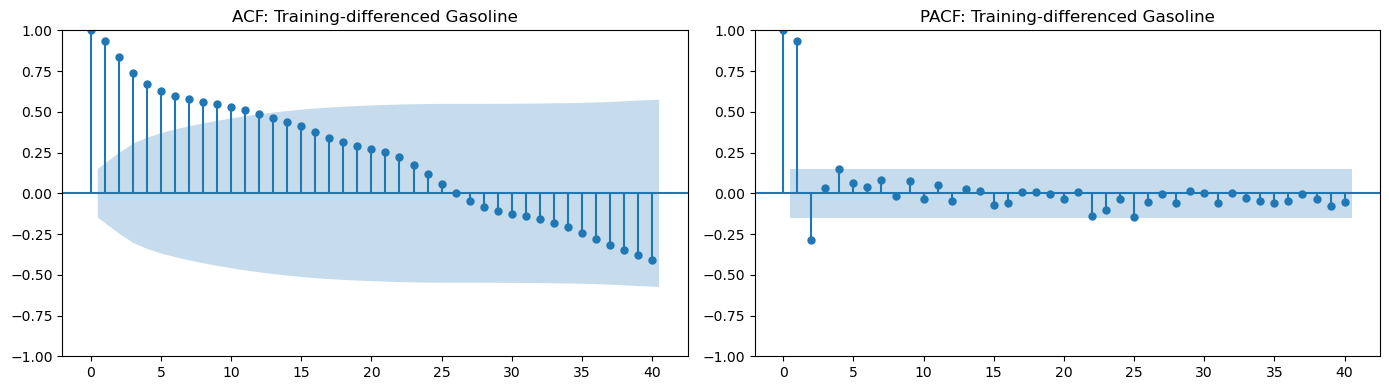

In [16]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
gas_yj_train = yj_df['Gasoline (Euro95) - Average price (F)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train   = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# Difference ONCE outside the model (because we'll set d=0, D=0)
exog_gas = gas_yj_train # np.diff(gas_yj_train)      # exogenous on same differenced scale as y
y       = y_yj_train # = np.diff(y_yj_train)         # this is your target_diff equivalent

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6               
start   = max_lag            # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_gas[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),   # <- if your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

    # Print summary of best lag for each metric
    best_aic  = results_sorted_aic[0]
    best_bic  = results_sorted_bic[0]
    best_aicc = results_sorted_aicc[0]

    print("\nSummary of best lag for each metric:")
    print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
    print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
    print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_gas, ax=plt.gca(), lags=40)
plt.title('ACF: Training-differenced Gasoline')

plt.subplot(1, 2, 2)
plot_pacf(exog_gas, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training-differenced Gasoline')

plt.tight_layout()
plt.show()


BASED ON THE RESULTS BEST LAGS ARE:

6,4,5

so we will test them all 3 and chekc best prediction

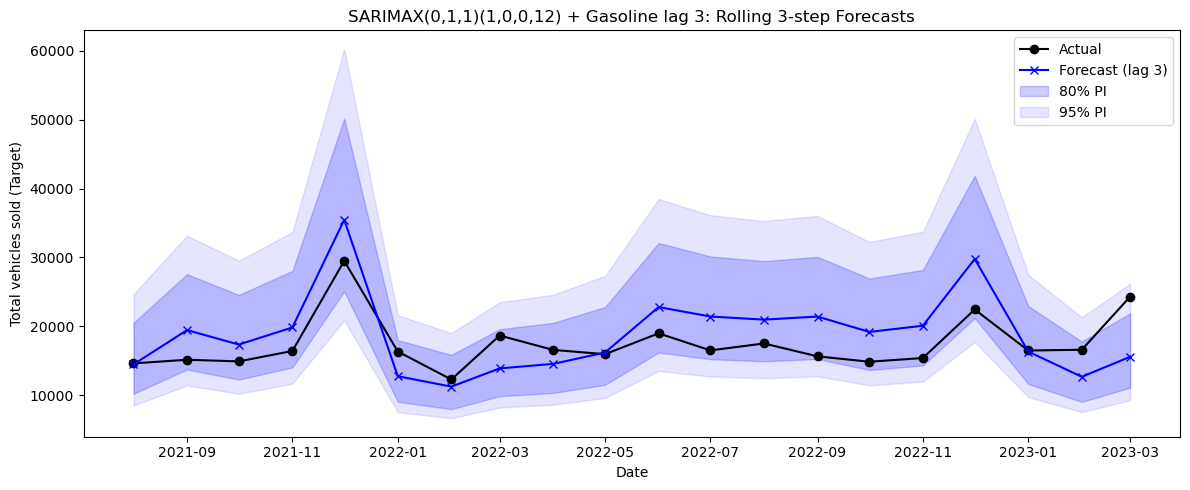

Lag 3: Validation RMSE (rolling): 4377.89
Lag 3: Validation MAPE (rolling): 20.81%


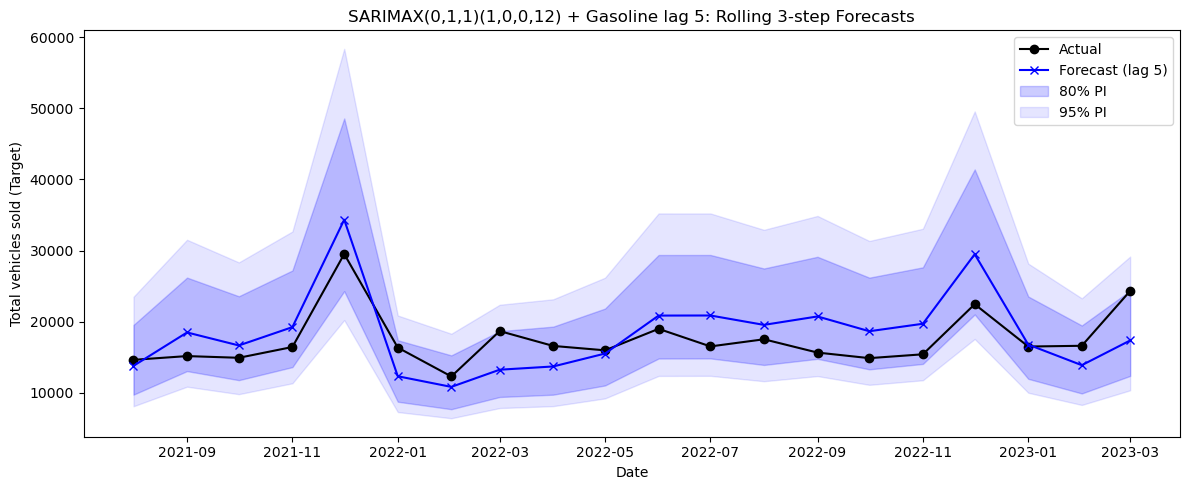

Lag 5: Validation RMSE (rolling): 3829.63
Lag 5: Validation MAPE (rolling): 18.54%


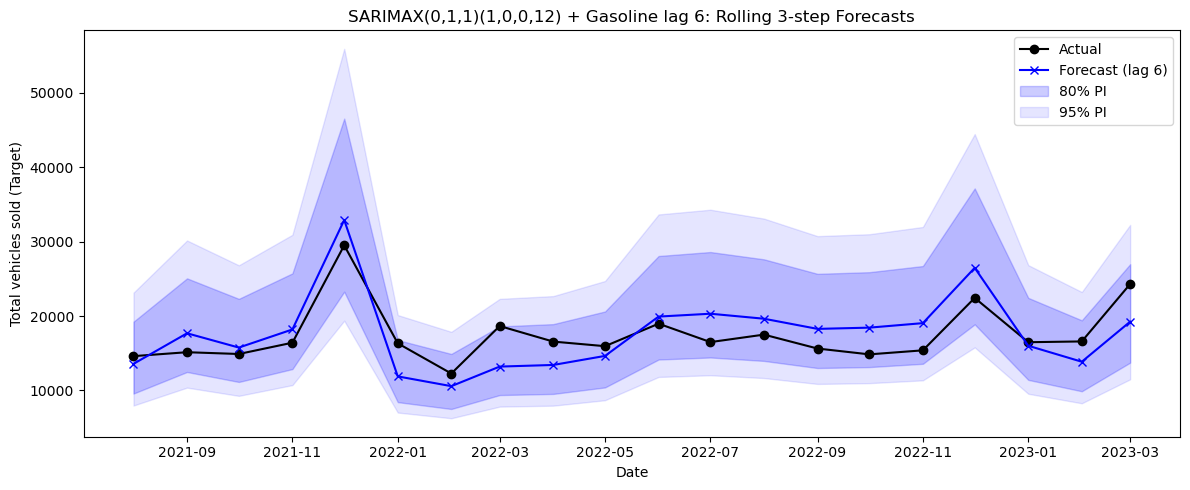

Lag 6: Validation RMSE (rolling): 3081.61
Lag 6: Validation MAPE (rolling): 15.64%

Summary of RMSE and MAPE for each lag:
Lag 3: RMSE=4377.89, MAPE=20.81%
Lag 5: RMSE=3829.63, MAPE=18.54%
Lag 6: RMSE=3081.61, MAPE=15.64%


In [17]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [3, 5, 6]

# --- Data ---
train_yj = y_train_yj.values  # Yeo-Johnson transformed training target as numpy array
val_yj   = y_val_yj.values    # Yeo-Johnson transformed validation target as numpy array
gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values  # Full YJ-transformed gasoline price as numpy array
n_train = len(train_yj)       # Number of training samples
n_val = len(val_yj)           # Number of validation samples
lam = yeojohnson_lambdas_all[target_raw]  # Yeo-Johnson lambda for the target variable

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        gas_hist = np.concatenate([gas_yj_full[:n_train], gas_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(gas_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        gas_future = gas_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,0,12) + Gasoline lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")

### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -19.56
BIC (last SARIMAX fit): -3.86


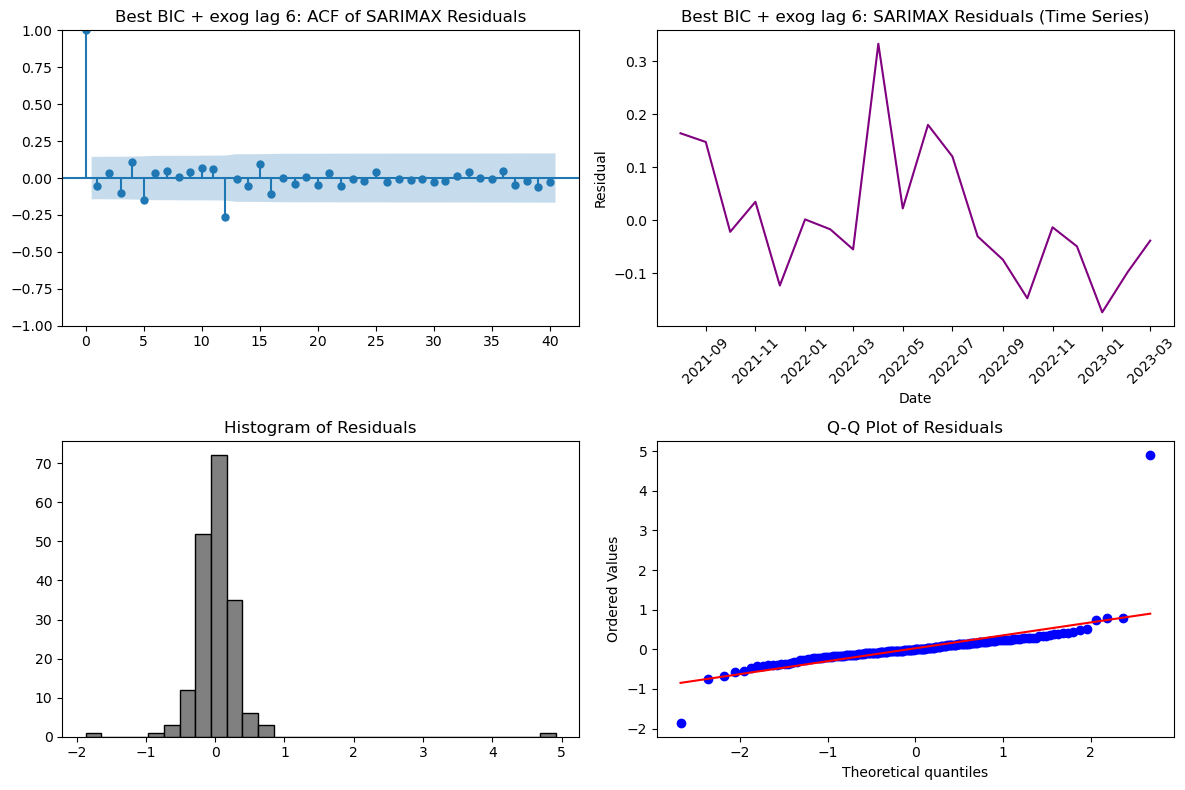

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.076748   0.351570
20  31.308784   0.051244
30  33.080320   0.319067


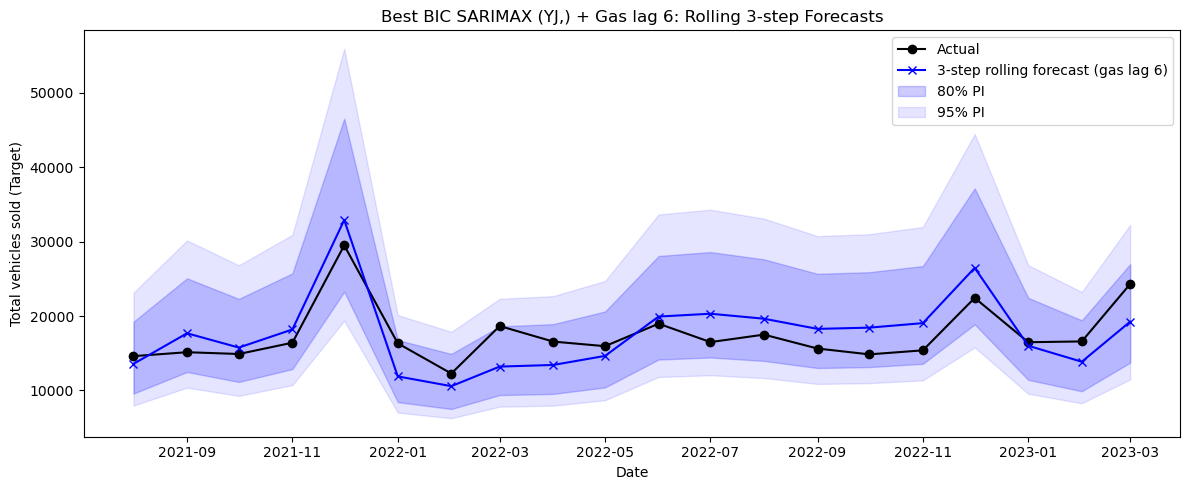

Validation RMSE (rolling): 3081.61
Validation MAPE (rolling): 15.64%


In [18]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 6  # Optimal lag for gasoline

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
n_train = len(train_yj)
n_val   = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation with exog lag=6
for t in range(n_val - horizon + 1):
    # Build expanding train + val window for target
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    # Exogenous feature: expanding window, with lag
    gas_hist = np.concatenate([gas_yj_full[:n_train], gas_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(gas_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    # Future exogenous values needed for forecast horizon
    gas_future = gas_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

    # SARIMAX model (best BIC model: (0,1,1)(1,0,0,12))
    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# Align actuals
actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
plot_dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag 6: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag 6: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (gas lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMAX (YJ,) + Gas lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

> testset check:


> voeg evt rmse van og model om beter te vergelijken, en verwijder de plots

## 7b Company car tax rate (%)

### Lag Selection

Optimal lags for Company car tax rate (%) (same sample):

By AIC:
  lag= 4  AIC=-15.65  BIC=-0.67  AICc=-15.27
  lag= 3  AIC=-14.98  BIC=0.04  AICc=-14.60
  lag= 2  AIC=-14.69  BIC=0.36  AICc=-14.32
  lag= 5  AIC=-13.60  BIC=1.36  AICc=-13.21
  lag= 6  AIC=-13.32  BIC=1.60  AICc=-12.93
  lag= 1  AIC=-6.29  BIC=8.80  AICc=-5.91
  lag= 0  AIC=-3.79  BIC=11.33  AICc=-3.41

By BIC:
  lag= 4  AIC=-15.65  BIC=-0.67  AICc=-15.27
  lag= 3  AIC=-14.98  BIC=0.04  AICc=-14.60
  lag= 2  AIC=-14.69  BIC=0.36  AICc=-14.32
  lag= 5  AIC=-13.60  BIC=1.36  AICc=-13.21
  lag= 6  AIC=-13.32  BIC=1.60  AICc=-12.93
  lag= 1  AIC=-6.29  BIC=8.80  AICc=-5.91
  lag= 0  AIC=-3.79  BIC=11.33  AICc=-3.41

By AICc:
  lag= 4  AIC=-15.65  BIC=-0.67  AICc=-15.27
  lag= 3  AIC=-14.98  BIC=0.04  AICc=-14.60
  lag= 2  AIC=-14.69  BIC=0.36  AICc=-14.32
  lag= 5  AIC=-13.60  BIC=1.36  AICc=-13.21
  lag= 6  AIC=-13.32  BIC=1.60  AICc=-12.93
  lag= 1  AIC=-6.29  BIC=8.80  AICc=-5.91
  lag= 0  AIC=-3.79  BIC=11.33  AICc=-3.

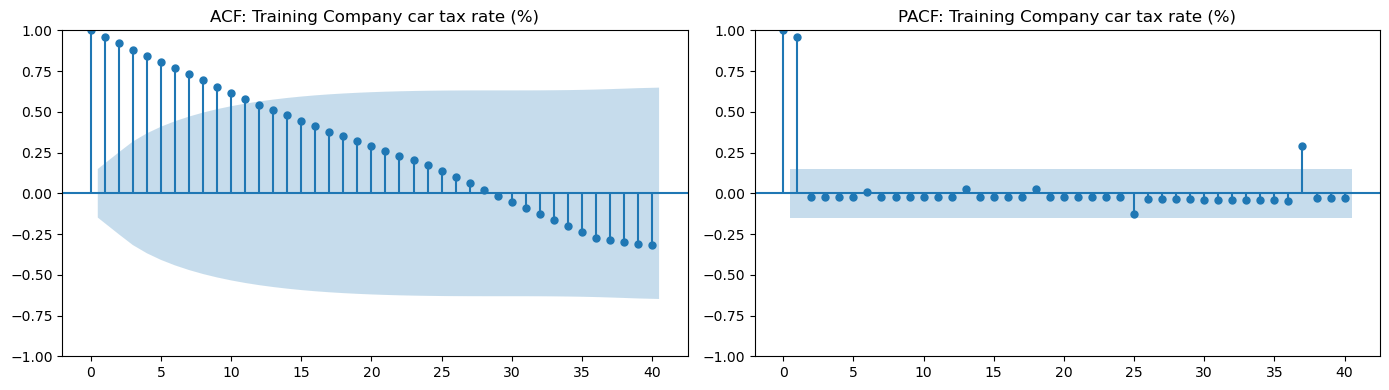

In [19]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
companytax_yj_train = yj_df['Company car tax rate (%)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train         = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# Difference ONCE outside the model (if you want d=0, but here keep d=1 as in your previous models)
exog_companytax = companytax_yj_train
y               = y_yj_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6
start   = max_lag      # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_companytax[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),   # If your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Company car tax rate (%) (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_companytax, ax=plt.gca(), lags=40)
plt.title('ACF: Training Company car tax rate (%)')

plt.subplot(1, 2, 2)
plot_pacf(exog_companytax, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training Company car tax rate (%)')

plt.tight_layout()
plt.show()

best lag for car tax rate is 6,4,5

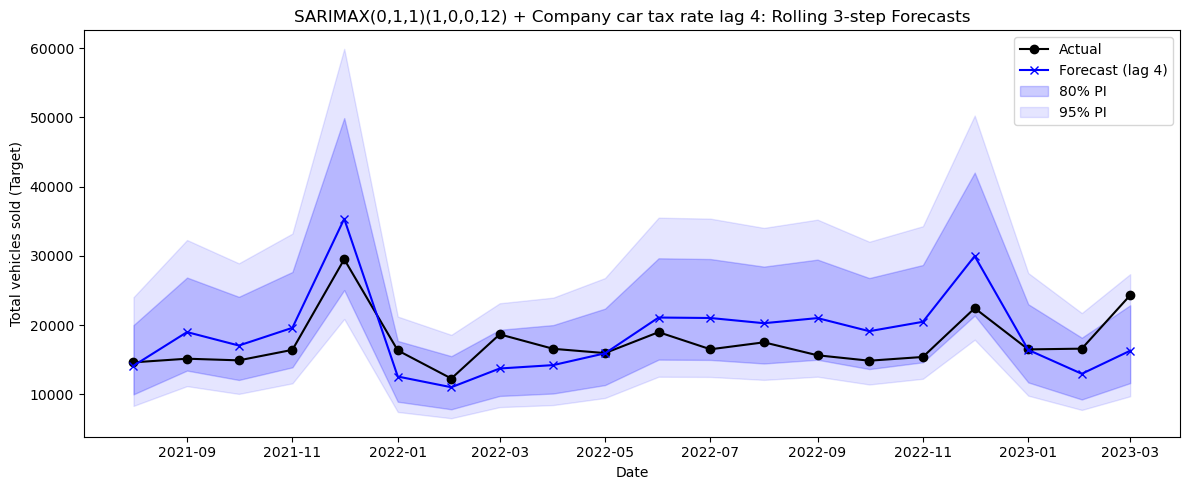

Lag 4: Validation RMSE (rolling): 4178.27
Lag 4: Validation MAPE (rolling): 19.78%


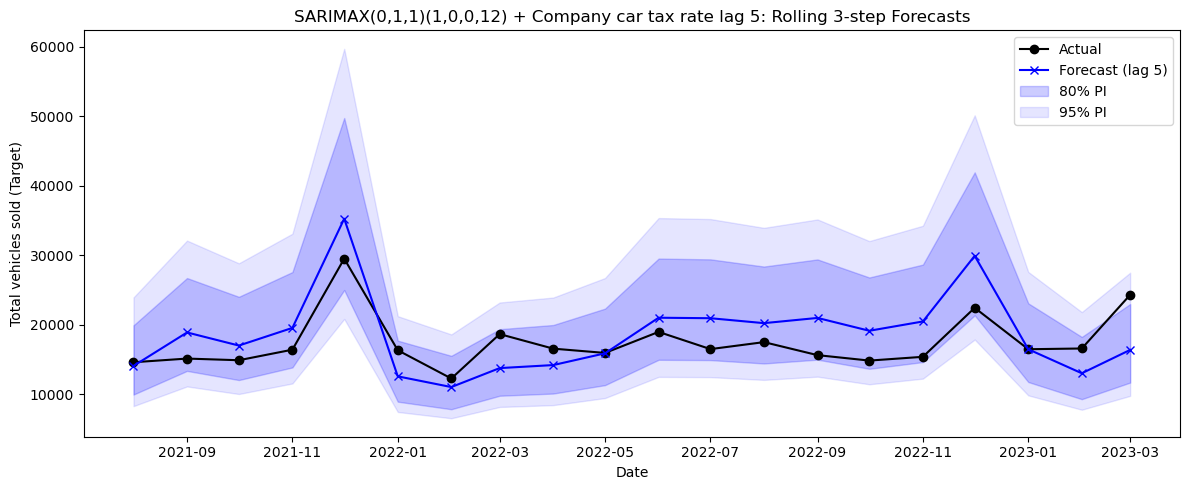

Lag 5: Validation RMSE (rolling): 4136.75
Lag 5: Validation MAPE (rolling): 19.58%


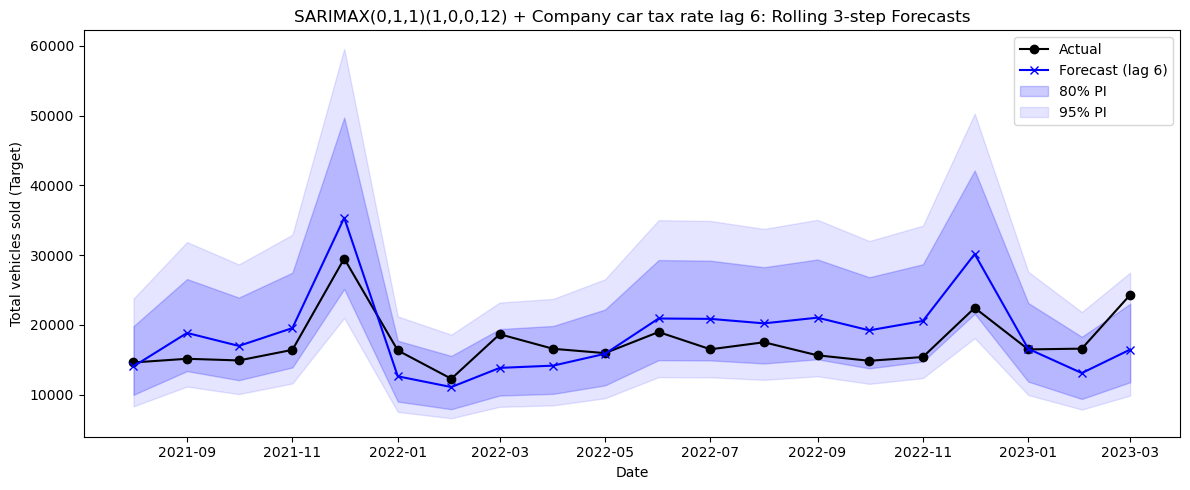

Lag 6: Validation RMSE (rolling): 4153.28
Lag 6: Validation MAPE (rolling): 19.62%

Summary of RMSE and MAPE for each lag:
Lag 4: RMSE=4178.27, MAPE=19.78%
Lag 5: RMSE=4136.75, MAPE=19.58%
Lag 6: RMSE=4153.28, MAPE=19.62%


In [20]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [4, 5, 6]  # <- use your top 3 lags for company car tax

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
tax_yj_full = yj_df['Company car tax rate (%)_yj'].values
n_train = len(train_yj)
n_val = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        tax_hist = np.concatenate([tax_yj_full[:n_train], tax_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(tax_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        tax_future = tax_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,0,12) + Company car tax rate lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")

### Fit Sarimax with cartax lag 5and diagnose 

AIC (last SARIMAX fit): -18.51
BIC (last SARIMAX fit): -2.77


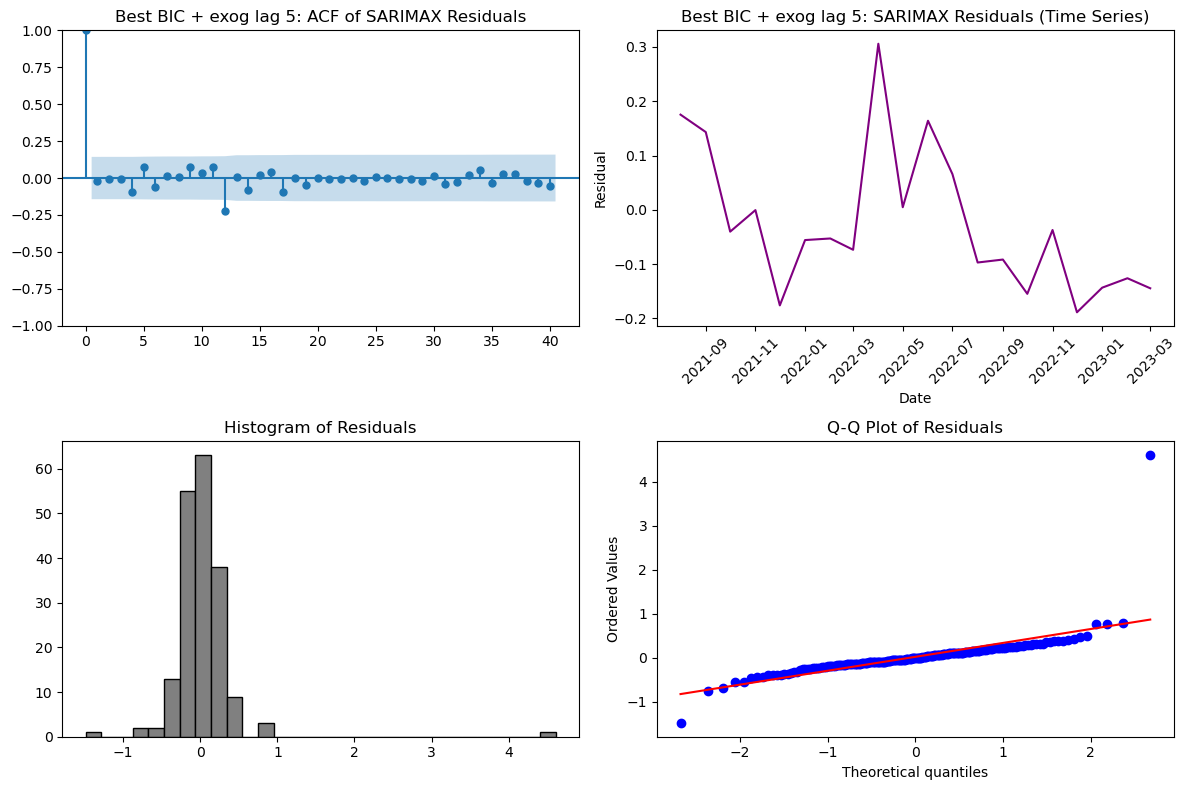

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10   5.034171   0.888884
20  20.254766   0.442098
30  20.498651   0.902908


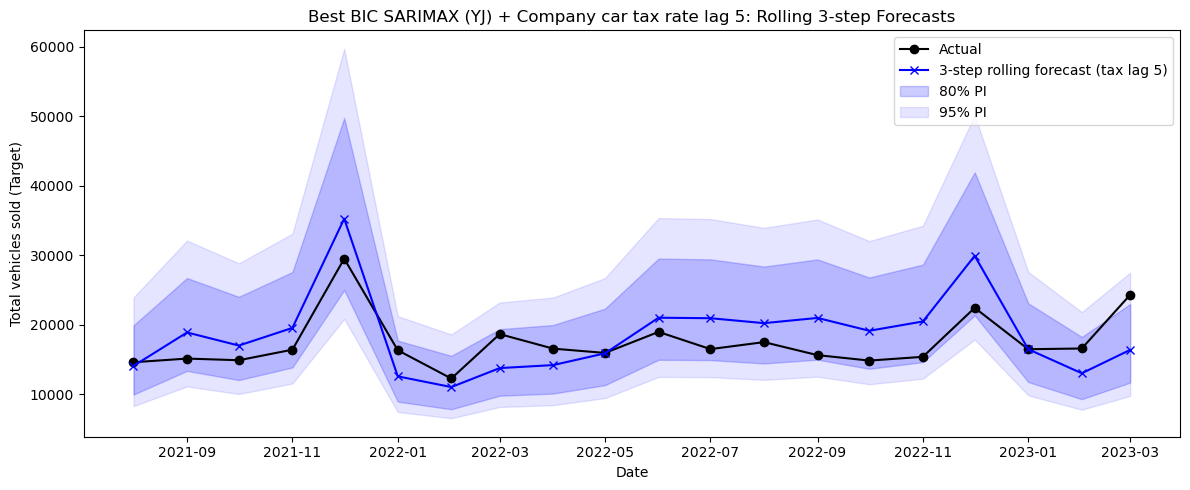

Validation RMSE (rolling): 4136.75
Validation MAPE (rolling): 19.58%


In [21]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 5  

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
# CHANGE TO COMPANY CAR TAX RATE AS EXOG
tax_yj_full = yj_df['Company car tax rate (%)_yj'].values
n_train = len(train_yj)
n_val   = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation with exog lag=5
for t in range(n_val - horizon + 1):
    # Build expanding train + val window for target
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    # Exogenous feature: expanding window, with lag
    tax_hist = np.concatenate([tax_yj_full[:n_train], tax_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(tax_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    # Future exogenous values needed for forecast horizon
    tax_future = tax_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

    # SARIMAX model (best BIC model: (0,1,1)(1,0,0,12))
    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# Align actuals
actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
plot_dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag 5: ACF of SARIMAX Residuals")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag 5: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (tax lag 5)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMAX (YJ) + Company car tax rate lag 5: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

testset check:

In [22]:

# warnings.filterwarnings("ignore")

# # --- Settings ---
# horizon = 3
# lag = 5  # <- BEST LAG FOR COMPANY CAR TAX

# # --- Data: use test set ---
# train_yj = np.concatenate([y_train_yj.values, y_val_yj.values])  # train+val for history
# test_yj = y_test_yj.values
# tax_yj_full = yj_df['Company car tax rate (%)_yj'].values
# n_train = len(train_yj)
# n_test = len(test_yj)
# lam = yeojohnson_lambdas_all[target_raw]

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     out[:lag] = np.nan
#     return out

# def inv_yeojohnson(z, lam):
#     if np.isclose(lam, 0):
#         return np.exp(z) - 1
#     elif lam == 2:
#         return -np.exp(-z)
#     out = np.zeros_like(z)
#     pos = z >= 0
#     out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
#     out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
#     return out

# preds_level = []
# ci80_lower = []
# ci80_upper = []
# ci95_lower = []
# ci95_upper = []

# # Rolling test evaluation with exog lag=5
# for t in range(n_test - horizon + 1):
#     # Build expanding train+test window for target
#     y_hist = np.concatenate([train_yj, test_yj[:t]])
#     idx_offset = n_train + t

#     # Exogenous feature: expanding window, with lag
#     tax_hist = np.concatenate([tax_yj_full[:n_train], tax_yj_full[n_train:n_train+t]])
#     exog_hist = make_lag(tax_hist, lag).reshape(-1, 1)
#     valid = ~np.isnan(exog_hist).flatten()
#     y_hist_valid = y_hist[valid]
#     exog_hist_valid = exog_hist[valid]

#     # Future exogenous values needed for forecast horizon
#     tax_future = tax_yj_full[:idx_offset + horizon]
#     exog_future_lag = make_lag(tax_future, lag)[-horizon:].reshape(-1, 1)

#     # SARIMAX model (best BIC model: (0,1,1)(1,0,0,12))
#     model = SARIMAX(
#         y_hist_valid,
#         exog=exog_hist_valid,
#         order=(0, 1, 1),
#         seasonal_order=(1, 0, 0, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted = model.fit(disp=False)

#     fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
#     yj_forecast_level = fc.predicted_mean[-1]

#     preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#     ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
#     ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
#     ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
#     ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
#     ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
#     ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# # Align actuals
# actuals_level = inv_yeojohnson(test_yj[horizon-1:], lam)
# plot_dates = df["Time Period (T)"].iloc[val_end_yj + horizon - 1 : test_end_yj][:len(preds_level)]

# # Diagnostics (last model in rolling)
# print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
# print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
# axes[0, 0].set_title("Best BIC + exog lag 5: ACF of SARIMAX Residuals")

# axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
# axes[0, 1].set_title("Best BIC + exog lag 5: SARIMAX Residuals (Time Series)")
# axes[0, 1].set_xlabel("Date")
# axes[0, 1].set_ylabel("Residual")
# axes[0, 1].tick_params(axis='x', rotation=45)

# axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
# axes[1, 0].set_title("Histogram of Residuals")
# stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title("Q-Q Plot of Residuals")
# plt.tight_layout()
# plt.show()

# lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
# print("Ljung-Box (no autocorrelation if p > 0.05):")
# print(lb[['lb_stat','lb_pvalue']])

# # Plot predictions
# plt.figure(figsize=(12, 5))
# plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
# plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (tax lag 5)')
# plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
# plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
# plt.title('Best BIC SARIMAX (YJ) + Company car tax rate lag 5: Rolling 3-step Forecasts (TEST)')
# plt.xlabel('Date')
# plt.ylabel(target_raw)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Metrics
# rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
# mape = mean_absolute_percentage_error(actuals_level, preds_level)
# print(f"Test RMSE (rolling): {rmse:.2f}")
# print(f"Test MAPE (rolling): {mape:.2%}")

## 7c Google Home Charging

### Lag Selection

Optimal lags for Home charging (G)_yj (same sample):

By AIC:
  lag= 5  AIC=-19.06  BIC=-4.11  AICc=-18.68
  lag= 2  AIC=-16.84  BIC=-1.79  AICc=-16.46
  lag= 3  AIC=-15.33  BIC=-0.31  AICc=-14.95
  lag= 4  AIC=-14.62  BIC=0.36  AICc=-14.24
  lag= 6  AIC=-12.80  BIC=2.12  AICc=-12.41
  lag= 1  AIC=-6.27  BIC=8.82  AICc=-5.89
  lag= 0  AIC=-3.81  BIC=11.31  AICc=-3.44

By BIC:
  lag= 5  AIC=-19.06  BIC=-4.11  AICc=-18.68
  lag= 2  AIC=-16.84  BIC=-1.79  AICc=-16.46
  lag= 3  AIC=-15.33  BIC=-0.31  AICc=-14.95
  lag= 4  AIC=-14.62  BIC=0.36  AICc=-14.24
  lag= 6  AIC=-12.80  BIC=2.12  AICc=-12.41
  lag= 1  AIC=-6.27  BIC=8.82  AICc=-5.89
  lag= 0  AIC=-3.81  BIC=11.31  AICc=-3.44

By AICc:
  lag= 5  AIC=-19.06  BIC=-4.11  AICc=-18.68
  lag= 2  AIC=-16.84  BIC=-1.79  AICc=-16.46
  lag= 3  AIC=-15.33  BIC=-0.31  AICc=-14.95
  lag= 4  AIC=-14.62  BIC=0.36  AICc=-14.24
  lag= 6  AIC=-12.80  BIC=2.12  AICc=-12.41
  lag= 1  AIC=-6.27  BIC=8.82  AICc=-5.89
  lag= 0  AIC=-3.81  BIC=11.31  AICc=-

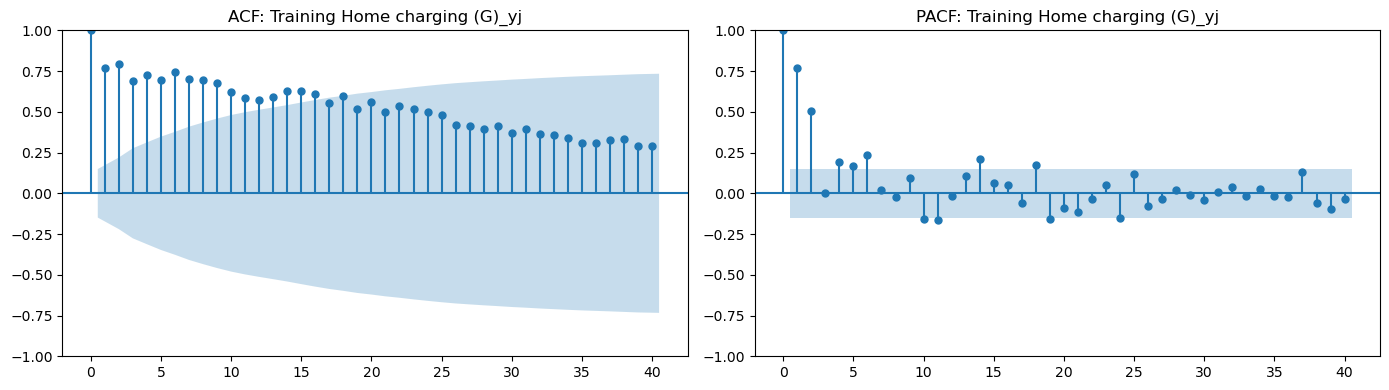

In [23]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
homechg_yj_train = yj_df['Home charging (G)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train      = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# (Optional: difference outside the model if you want d=0, but here we keep d=1)
exog_homechg = homechg_yj_train
y            = y_yj_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6
start   = max_lag      # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_homechg[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),   # <- adjust if your best seasonal is (0,0,1,12)
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Home charging (G)_yj (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_homechg, ax=plt.gca(), lags=40)
plt.title('ACF: Training Home charging (G)_yj')

plt.subplot(1, 2, 2)
plot_pacf(exog_homechg, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training Home charging (G)_yj')

plt.tight_layout()
plt.show()

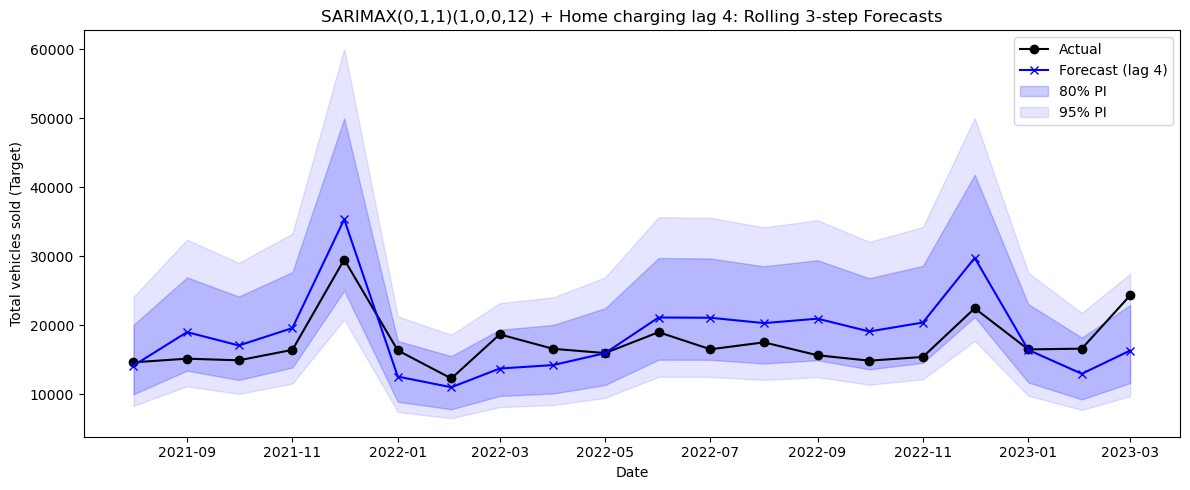

Lag 4: Validation RMSE (rolling): 4147.14
Lag 4: Validation MAPE (rolling): 19.69%


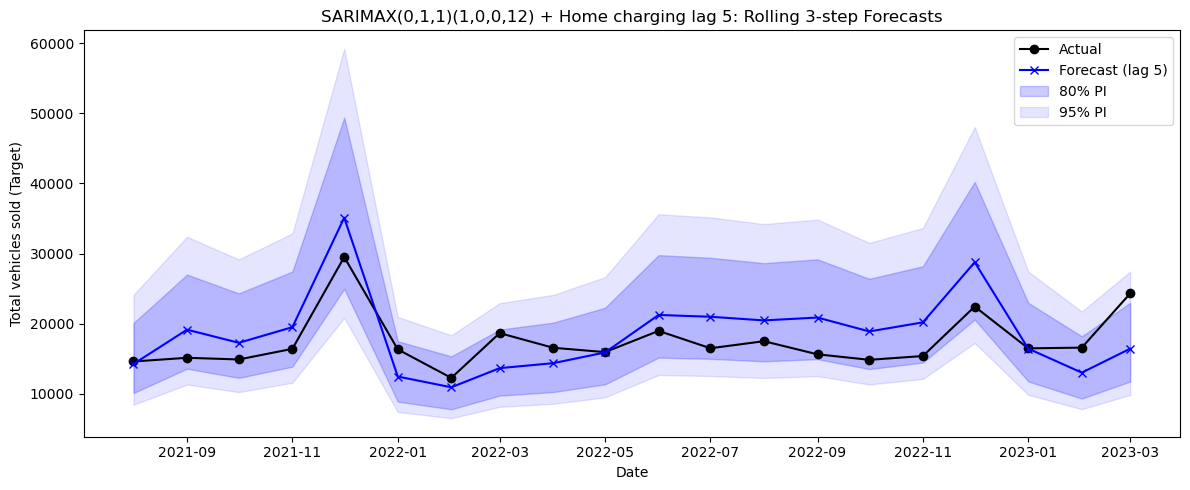

Lag 5: Validation RMSE (rolling): 4031.28
Lag 5: Validation MAPE (rolling): 19.40%


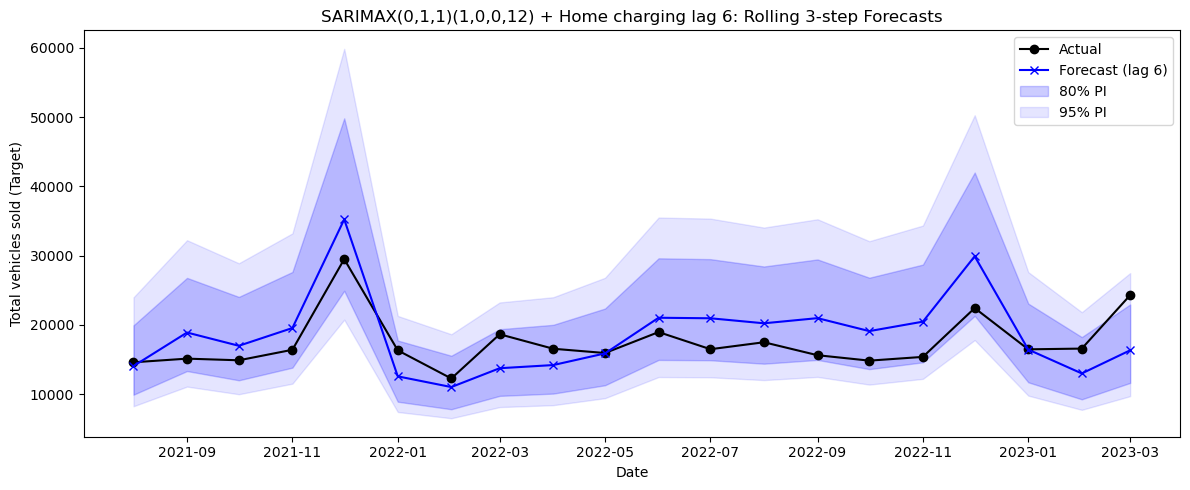

Lag 6: Validation RMSE (rolling): 4144.55
Lag 6: Validation MAPE (rolling): 19.63%

Summary of RMSE and MAPE for each lag:
Lag 4: RMSE=4147.14, MAPE=19.69%
Lag 5: RMSE=4031.28, MAPE=19.40%
Lag 6: RMSE=4144.55, MAPE=19.63%


In [24]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [4, 5, 6]

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
homechg_yj_full = yj_df['Home charging (G)_yj'].values  # <-- use home charging, not gas
n_train = len(train_yj)
n_val   = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        homechg_hist = np.concatenate([homechg_yj_full[:n_train], homechg_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(homechg_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        homechg_future = homechg_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,0,12) + Home charging lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")

### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -17.42
BIC (last SARIMAX fit): -1.71


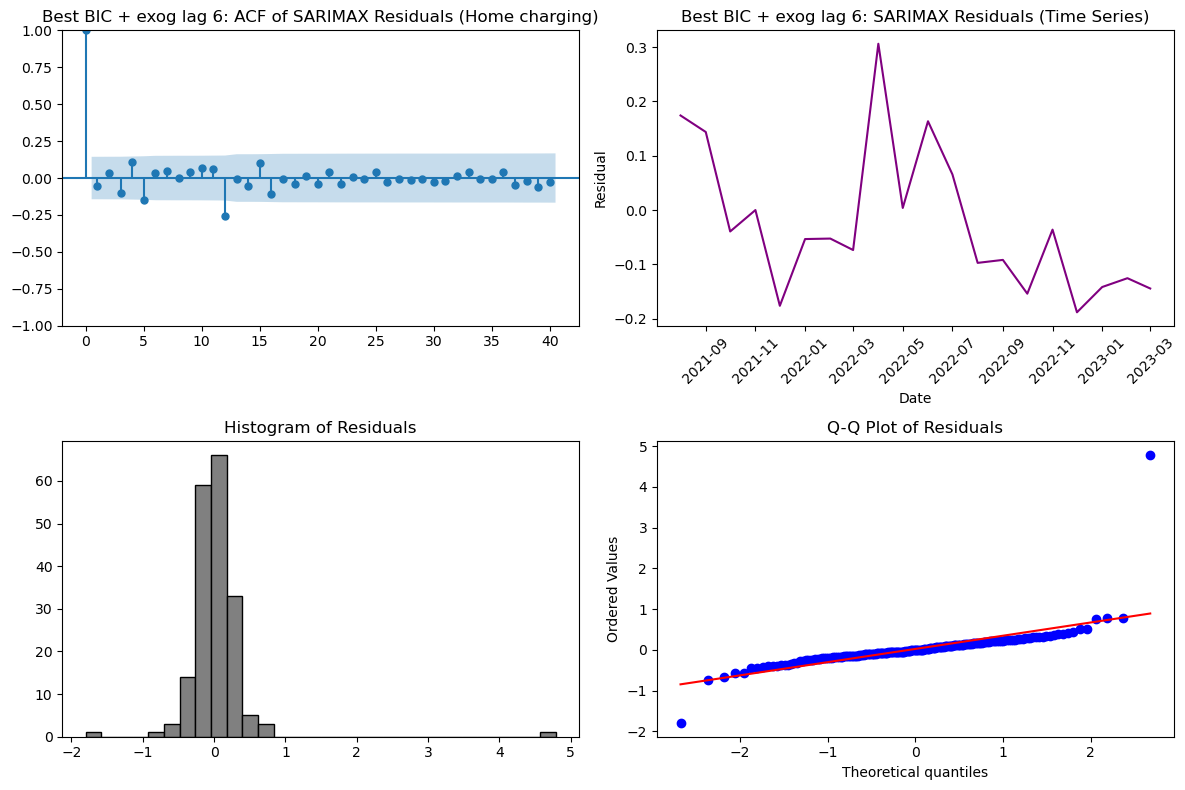

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.123567   0.347972
20  31.162717   0.053079
30  32.721643   0.334749


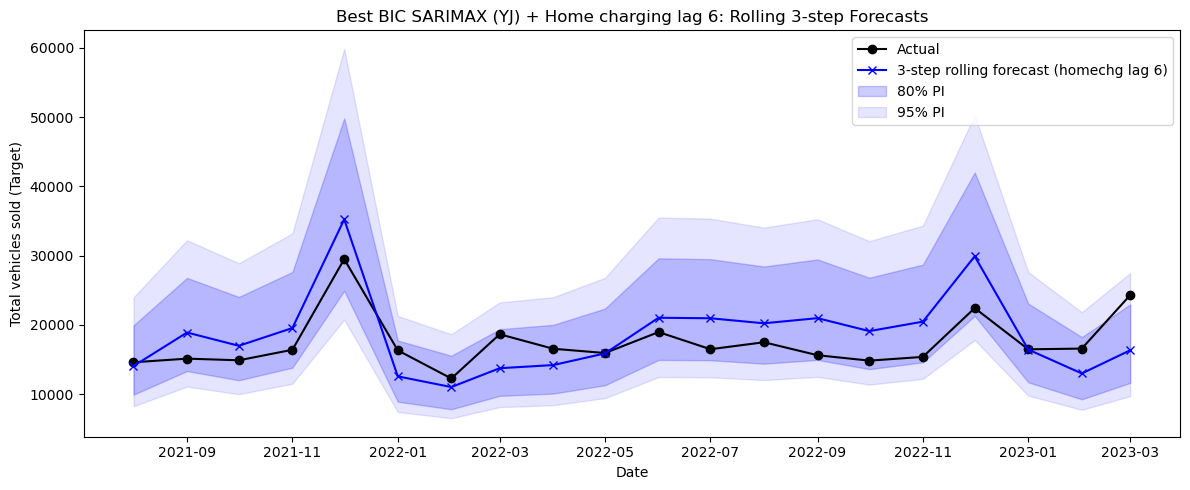

Validation RMSE (rolling): 4144.55
Validation MAPE (rolling): 19.63%


In [25]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 6  # Optimal lag for Home Charging

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
homechg_yj_full = yj_df['Home charging (G)_yj'].values   # <-- Use Home charging instead of gas
n_train = len(train_yj)
n_val   = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation with exog lag=6
for t in range(n_val - horizon + 1):
    # Build expanding train + val window for target
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    # Exogenous feature: expanding window, with lag
    homechg_hist = np.concatenate([homechg_yj_full[:n_train], homechg_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(homechg_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    # Future exogenous values needed for forecast horizon
    homechg_future = homechg_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(homechg_future, lag)[-horizon:].reshape(-1, 1)

    # SARIMAX model (same seasonal order as before)
    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# Align actuals
actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
plot_dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]

# Diagnostics (last model in rolling)
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("Best BIC + exog lag 6: ACF of SARIMAX Residuals (Home charging)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag 6: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (homechg lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMAX (YJ) + Home charging lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")


## 7d Consumer confidence (E)

### Lag Selection

Optimal lags for Consumer confidence (E)_yj (same sample):

By AIC:
  lag= 4  AIC=-11.49  BIC=0.55  AICc=-11.24
  lag= 5  AIC=-11.32  BIC=0.69  AICc=-11.07
  lag= 6  AIC=-11.22  BIC=0.77  AICc=-10.97
  lag= 1  AIC=-3.74  BIC=8.38  AICc=-3.49
  lag= 0  AIC=-3.64  BIC=8.51  AICc=-3.39
  lag= 2  AIC=-2.78  BIC=9.31  AICc=-2.53
  lag= 3  AIC=-1.04  BIC=11.03  AICc=-0.78

By BIC:
  lag= 4  AIC=-11.49  BIC=0.55  AICc=-11.24
  lag= 5  AIC=-11.32  BIC=0.69  AICc=-11.07
  lag= 6  AIC=-11.22  BIC=0.77  AICc=-10.97
  lag= 1  AIC=-3.74  BIC=8.38  AICc=-3.49
  lag= 0  AIC=-3.64  BIC=8.51  AICc=-3.39
  lag= 2  AIC=-2.78  BIC=9.31  AICc=-2.53
  lag= 3  AIC=-1.04  BIC=11.03  AICc=-0.78

By AICc:
  lag= 4  AIC=-11.49  BIC=0.55  AICc=-11.24
  lag= 5  AIC=-11.32  BIC=0.69  AICc=-11.07
  lag= 6  AIC=-11.22  BIC=0.77  AICc=-10.97
  lag= 1  AIC=-3.74  BIC=8.38  AICc=-3.49
  lag= 0  AIC=-3.64  BIC=8.51  AICc=-3.39
  lag= 2  AIC=-2.78  BIC=9.31  AICc=-2.53
  lag= 3  AIC=-1.04  BIC=11.03  AICc=-0.78

Summary o

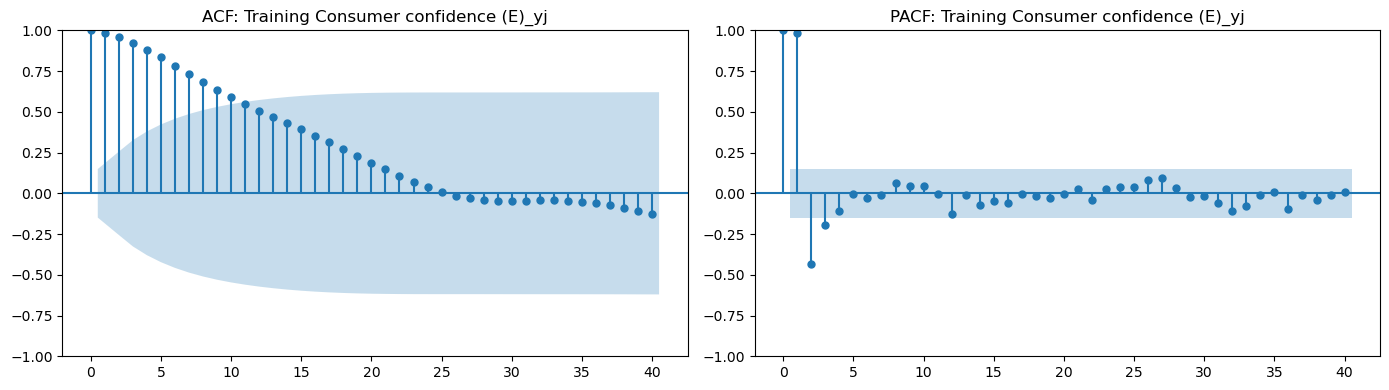

In [26]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
conf_yj_train = yj_df['Consumer confidence (E)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train    = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# No explicit differencing outside the model, d=1 in SARIMAX will handle it
exog_conf = conf_yj_train
y         = y_yj_train

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6
start   = max_lag  # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_conf[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 12),
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags for Consumer confidence (E)_yj (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

# Print summary of best lag for each metric
best_aic  = results_sorted_aic[0]
best_bic  = results_sorted_bic[0]
best_aicc = results_sorted_aicc[0]

print("\nSummary of best lag for each metric:")
print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_conf, ax=plt.gca(), lags=40)
plt.title('ACF: Training Consumer confidence (E)_yj')

plt.subplot(1, 2, 2)
plot_pacf(exog_conf, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training Consumer confidence (E)_yj')

plt.tight_layout()
plt.show()

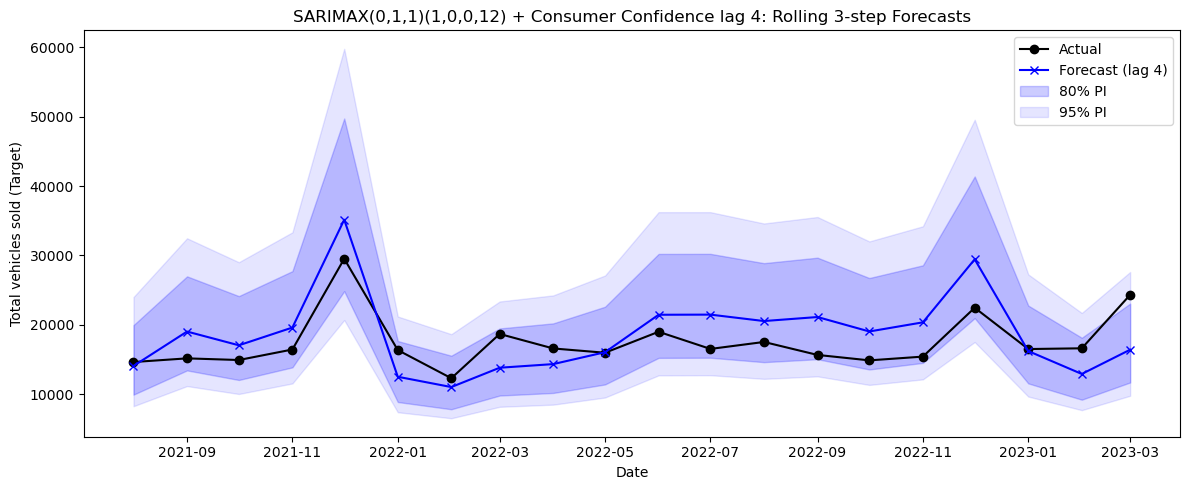

Lag 4: Validation RMSE (rolling): 4143.91
Lag 4: Validation MAPE (rolling): 19.96%


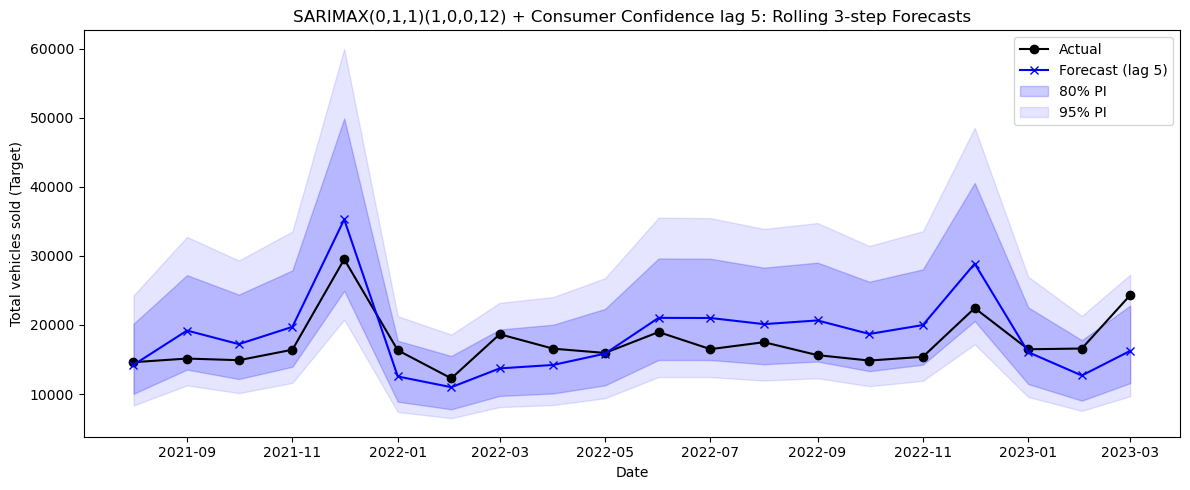

Lag 5: Validation RMSE (rolling): 4038.96
Lag 5: Validation MAPE (rolling): 19.42%


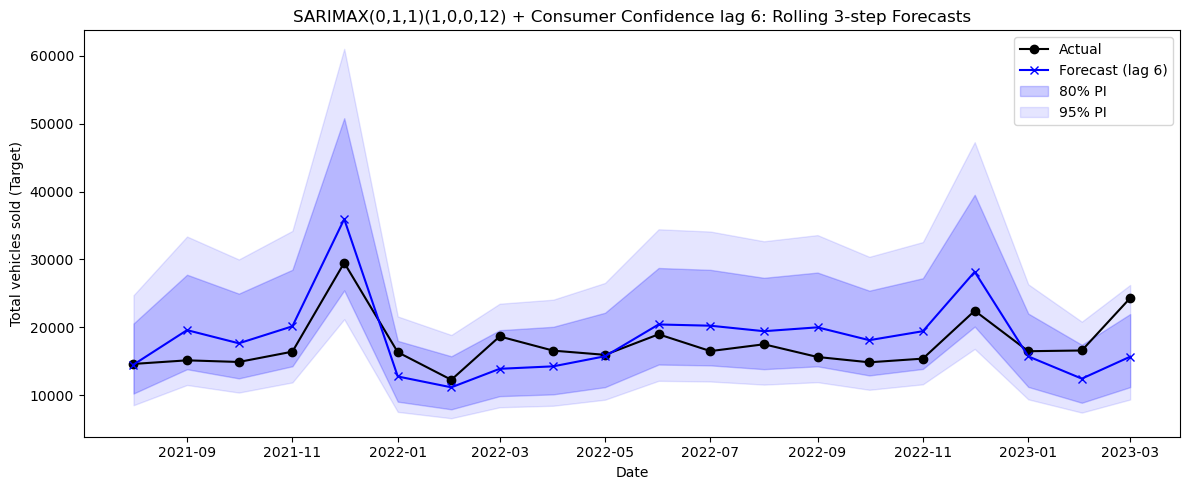

Lag 6: Validation RMSE (rolling): 3973.50
Lag 6: Validation MAPE (rolling): 18.64%

Summary of RMSE and MAPE for each lag:
Lag 4: RMSE=4143.91, MAPE=19.96%
Lag 5: RMSE=4038.96, MAPE=19.42%
Lag 6: RMSE=3973.50, MAPE=18.64%


In [27]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [4, 5, 6]  # Top 3 lags from your test

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
conf_yj_full = yj_df['Consumer confidence (E)_yj'].values  # Use Consumer confidence
n_train = len(train_yj)
n_val = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(conf_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        conf_future = conf_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(0,1,1)(1,0,0,12) + Consumer Confidence lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")


### Fit Sarimax and diagnose 

AIC (last SARIMAX fit): -18.75
BIC (last SARIMAX fit): -3.04


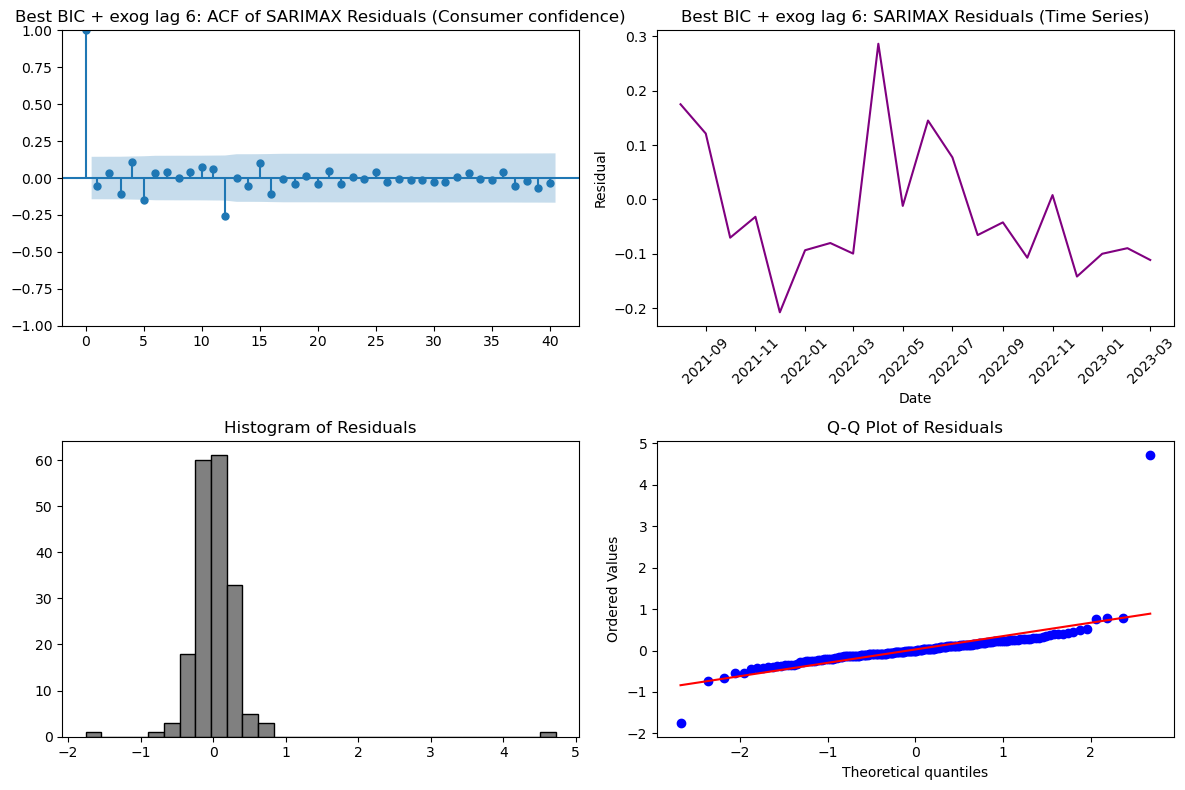

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.447986   0.323696
20  31.076328   0.054191
30  32.735908   0.334117


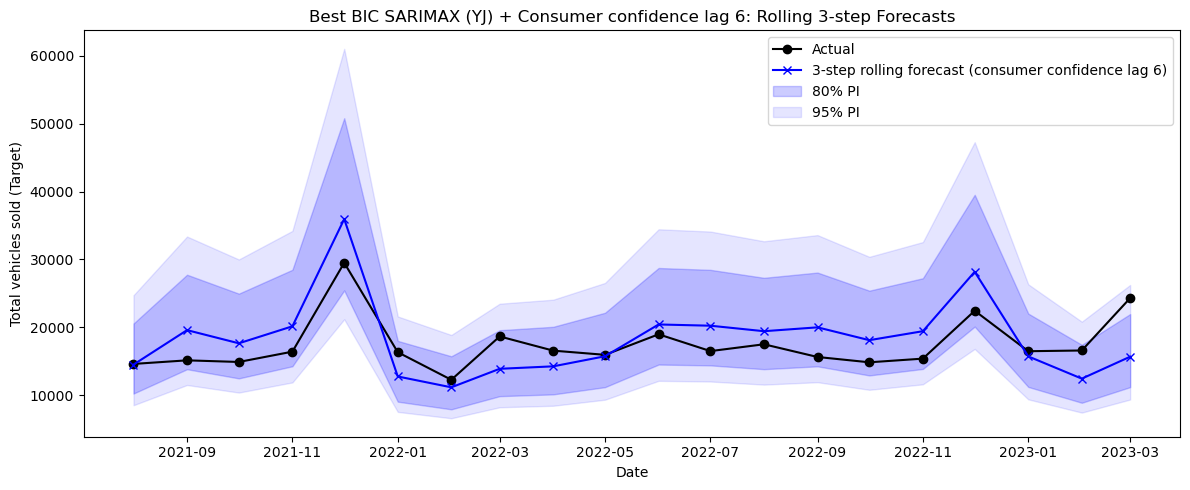

Validation RMSE (rolling): 3973.50
Validation MAPE (rolling): 18.64%


In [28]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lag = 6  # Optimal lag for Consumer confidence

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
conf_yj_full = yj_df['Consumer confidence (E)_yj'].values  # Use Consumer confidence as exog
n_train = len(train_yj)
n_val   = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

# Rolling validation with exog lag=4
for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train+t]])
    exog_hist = make_lag(conf_hist, lag).reshape(-1, 1)
    valid = ~np.isnan(exog_hist).flatten()
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    conf_future = conf_yj_full[:idx_offset + horizon]
    exog_future_lag = make_lag(conf_future, lag)[-horizon:].reshape(-1, 1)

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
plot_dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)  # Plot the autocorrelation function of the residuals to check for remaining autocorrelation after model fitting
axes[0, 0].set_title("Best BIC + exog lag 6: ACF of SARIMAX Residuals (Consumer confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("Best BIC + exog lag 6: SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45) 

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (consumer confidence lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best BIC SARIMAX (YJ) + Consumer confidence lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 8 All features together/ turn this into top features together


| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |

| Model / Feature       | Lag | RMSE    | MAPE   | Beat Baseline?               | Difference (RMSE)      |
| --------------------- | --- | ------- | ------ | ---------------------------- | ---------------------- |
| **Benchmark**         |     |         |        |                              |                        |
| Naïve 3-step          | —   | 5360.99 | 19.05% | No                           | +1948.31               |
| Seasonal Naïve 3-step | —   | 4456.62 | 21.24% | No                           | +1043.94               |
| Drift 3-step          | —   | 4923.98 | 20.04% | No                           | +1511.30               |
| **Baseline**          | —   | 3412.68 | 17.12% | —                            | 0                      |
| Gasoline price        | 6   | 2503.25 | 12.06% | **Yes (better RMSE & MAPE)** | -909.43                |
| Company car tax       | 5   | 3469.03 | 17.42% | No                           | +56.35                 |
| Google home charging  | 6   | 3467.37 | 17.41% | No                           | +54.69                 |
| Consumer confidence   | 6   | 3381.23 | 15.95% | **Yes (better RMSE & MAPE)** | -31.45                 |


| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |




**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

AIC (last SARIMAX fit): -19.07
BIC (last SARIMAX fit): -0.22


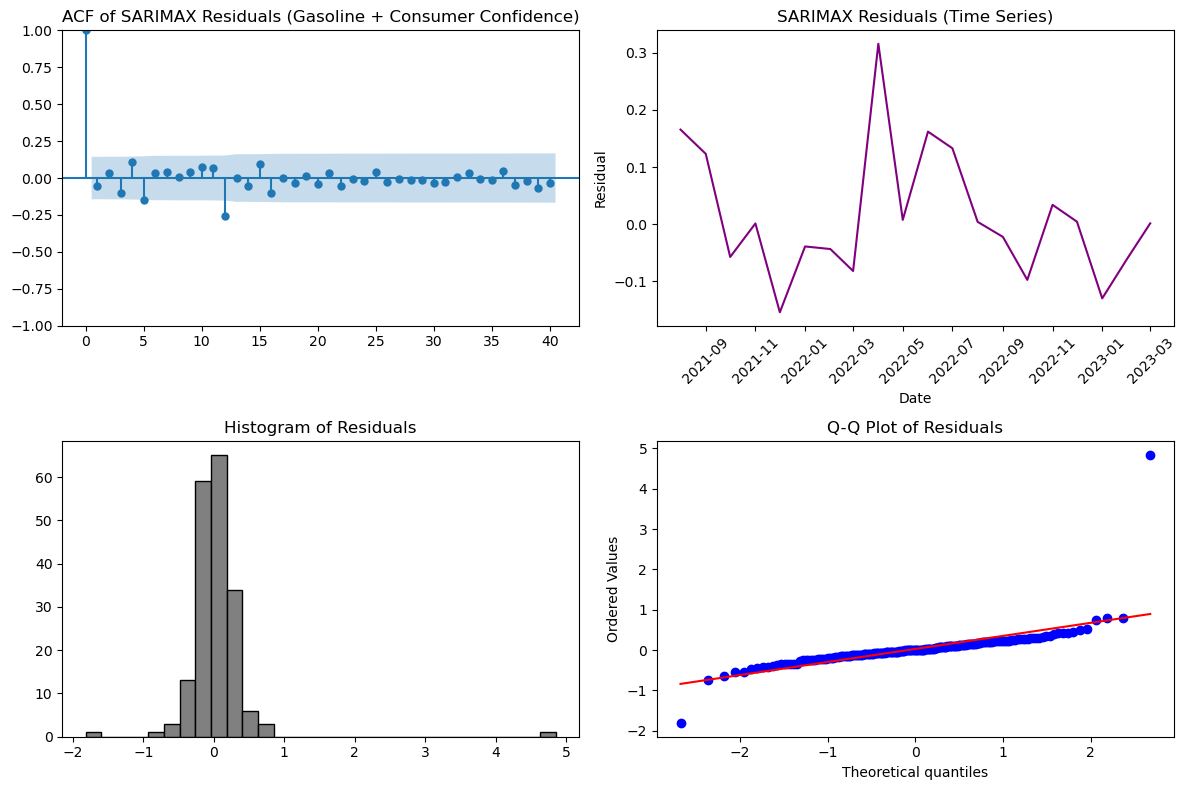

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  11.446351   0.323816
20  31.251916   0.051951
30  33.131578   0.316860


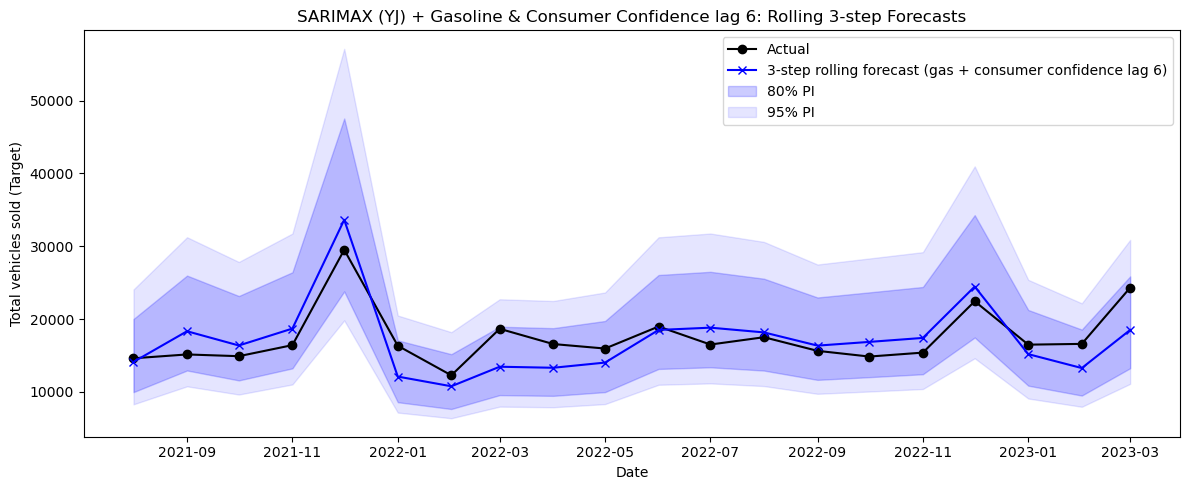

Validation RMSE (rolling): 2840.76
Validation MAPE (rolling): 13.61%


In [29]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # lag 6 for both features

# Data
train_yj = y_train_yj.values
val_yj = y_val_yj.values
gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
conf_yj_full = yj_df['Consumer confidence (E)_yj'].values
n_train = len(train_yj)
n_val = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_val - horizon + 1):
    y_hist = np.concatenate([train_yj, val_yj[:t]])
    idx_offset = n_train + t

    gas_hist = np.concatenate([gas_yj_full[:n_train], gas_yj_full[n_train:n_train + t]])
    conf_hist = np.concatenate([conf_yj_full[:n_train], conf_yj_full[n_train:n_train + t]])

    # Create lagged exog features
    exog_gas_lag = make_lag(gas_hist, lag)
    exog_conf_lag = make_lag(conf_hist, lag)

    # Combine lagged exogs into one array (columns = features)
    exog_hist = np.column_stack((exog_gas_lag, exog_conf_lag))
    valid = ~np.isnan(exog_hist).any(axis=1)
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future = gas_yj_full[:idx_offset + horizon]
    conf_future = conf_yj_full[:idx_offset + horizon]

    exog_future_gas = make_lag(gas_future, lag)
    exog_future_conf = make_lag(conf_future, lag)
    exog_future_lag = np.column_stack((exog_future_gas[-horizon:], exog_future_conf[-horizon:]))

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(val_yj[horizon - 1:], lam)
plot_dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1:val_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (Gasoline + Consumer Confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (gas + consumer confidence lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (YJ) + Gasoline & Consumer Confidence lag 6: Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

# 6 Plot/evaluate with target value on test

NAIVE OP TEST


Naïve 3-step RMSE (test): 5141.40
Naïve 3-step MAPE (test): 11.88%
Seasonal Naïve 3-step RMSE (test): 18462.87
Seasonal Naïve 3-step MAPE (test): 59.51%
Drift 3-step RMSE (test): 11152.71
Drift 3-step MAPE (test): 37.15%


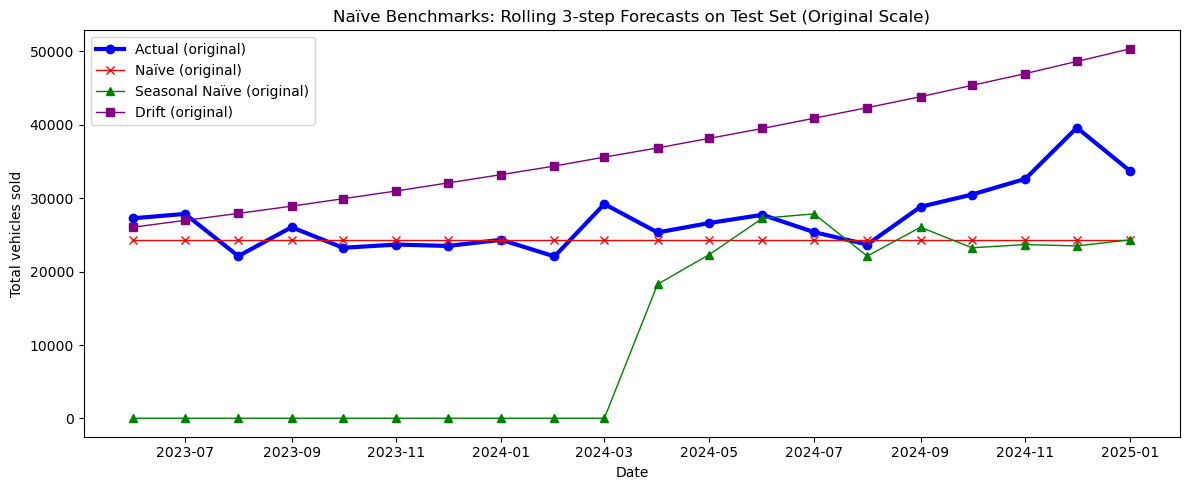

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

horizon = 3  # Forecast horizon

# Gebruik train + val voor volledige trainingsreeks
y_train_val_yj = np.concatenate([y_train_yj.values, y_val_yj.values])
# y_test_yj is already a numpy array

# Lengtes voor indexering
train_val_end = len(y_train_val_yj)
test_len = len(y_test_yj)

# === 1. Naïeve voorspelling (YJ) op testset ===
naive_preds_yj = []
for t in range(test_len - horizon + 1):
    # Use the last observed value from the train+val set for each forecast
    last_obs = y_train_val_yj[-1]
    naive_preds_yj.append(last_obs)
naive_preds_yj = np.array(naive_preds_yj)
naive_actuals_yj = y_test_yj[horizon-1:]

# === 2. Seizoensgebonden naïeve voorspelling (12 maanden terug) op testset ===
season_length = 12
seasonal_naive_preds_yj = []
for t in range(test_len - horizon + 1):
    # For seasonal naive, use the value from season_length steps ago in test set if available
    if t - season_length + horizon - 1 >= 0:
        pred = y_test_yj[t - season_length + horizon - 1]
    else:
        pred = y_train_val_yj[-season_length + t + horizon - 1] if (-season_length + t + horizon - 1) >= 0 else y_train_val_yj[0]
    seasonal_naive_preds_yj.append(pred)
seasonal_naive_preds_yj = np.array(seasonal_naive_preds_yj)

# === 3. Drift voorspelling (YJ) op testset ===
drift_preds_yj = []
n_train_val = len(y_train_val_yj)
for t in range(test_len - horizon + 1):
    # Drift forecast: extrapolate line from first to last train+val point
    drift = y_train_val_yj[-1] + ((t + horizon - 1) * (y_train_val_yj[-1] - y_train_val_yj[0]) / (n_train_val - 1))
    drift_preds_yj.append(drift)
drift_preds_yj = np.array(drift_preds_yj)

# Inverse transform functie Yeo-Johnson (zelfde als jouw oorspronkelijke)
lam = yeojohnson_lambdas_all[target_raw]
def inv_yeojohnson(z, lam):
    out = np.zeros_like(z)
    pos = z >= 0
    if np.isclose(lam, 0):
        out[pos] = np.exp(z[pos]) - 1
    elif lam == 2:
        out[pos] = -np.exp(-z[pos])
    else:
        out[pos] = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

# Omzetten naar originele schaal
actuals_orig = inv_yeojohnson(naive_actuals_yj, lam)
naive_preds_orig = inv_yeojohnson(naive_preds_yj, lam)
seasonal_naive_preds_orig = inv_yeojohnson(seasonal_naive_preds_yj, lam)
drift_preds_orig = inv_yeojohnson(drift_preds_yj, lam)

# Metrics berekenen op originele schaal
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, naive_preds_orig))
naive_mape_orig = mean_absolute_percentage_error(actuals_orig, naive_preds_orig)

seasonal_naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, seasonal_naive_preds_orig))
seasonal_naive_mape_orig = mean_absolute_percentage_error(actuals_orig, seasonal_naive_preds_orig)

drift_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, drift_preds_orig))
drift_mape_orig = mean_absolute_percentage_error(actuals_orig, drift_preds_orig)

print(f"Naïve 3-step RMSE (test): {naive_rmse_orig:.2f}")
print(f"Naïve 3-step MAPE (test): {naive_mape_orig:.2%}")
print(f"Seasonal Naïve 3-step RMSE (test): {seasonal_naive_rmse_orig:.2f}")
print(f"Seasonal Naïve 3-step MAPE (test): {seasonal_naive_mape_orig:.2%}")
print(f"Drift 3-step RMSE (test): {drift_rmse_orig:.2f}")
print(f"Drift 3-step MAPE (test): {drift_mape_orig:.2%}")

# Optioneel: plotten
import matplotlib.pyplot as plt

x_dates_test = df["Time Period (T)"].iloc[val_end_yj + horizon - 1 : test_end_yj]

plt.figure(figsize=(12, 5))
plt.plot(x_dates_test, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_test, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_test, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_test, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Test Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


AIC (last SARIMAX fit): -36.48
BIC (last SARIMAX fit): -16.90


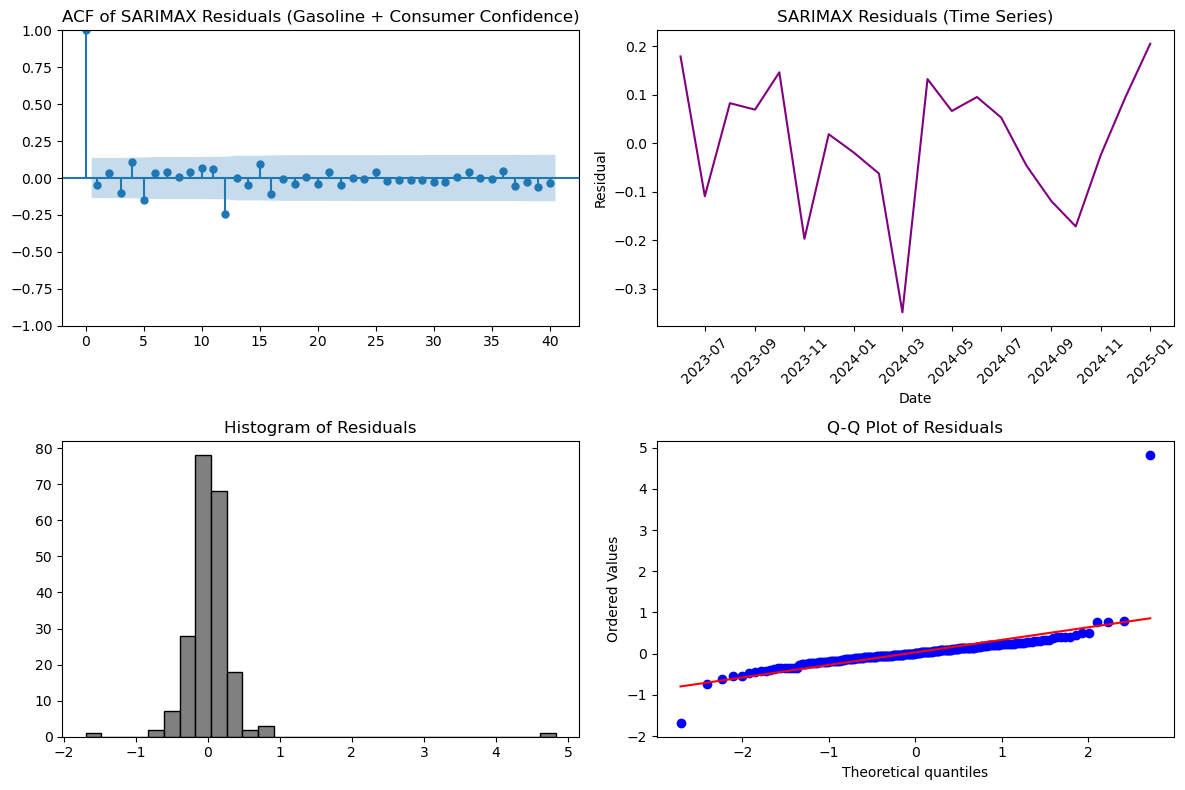

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  12.408006   0.258678
20  32.658867   0.036764
30  34.504870   0.261101


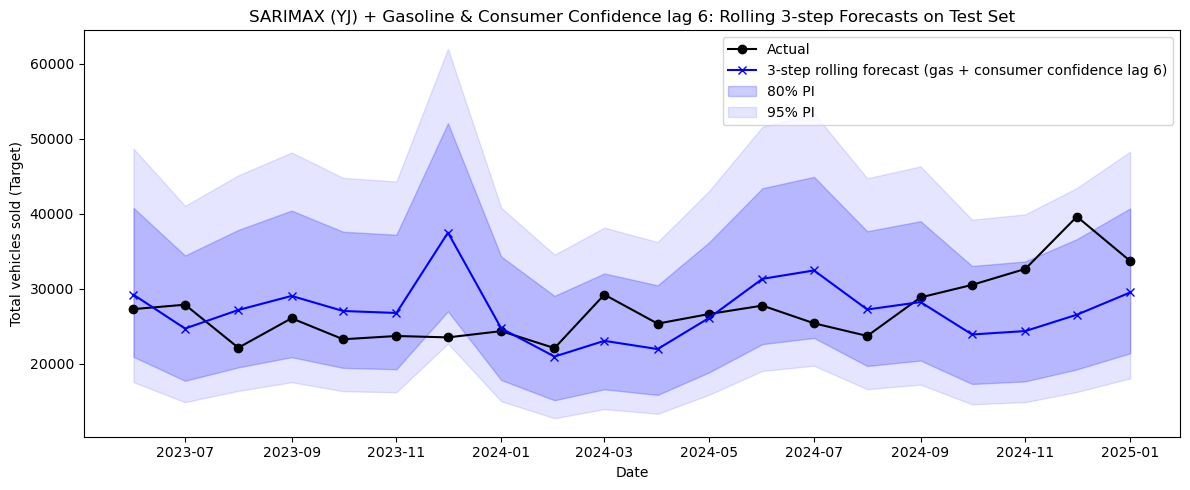

Test RMSE (rolling): 5891.37
Test MAPE (rolling): 16.73%


In [30]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # lag 6 for both features

# Combine train + val for fitting initial model
train_val_yj = np.concatenate([y_train_yj.values, y_val_yj.values])
test_yj = y_test_yj.values

gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
conf_yj_full = yj_df['Consumer confidence (E)_yj'].values

n_train_val = len(train_val_yj)
n_test = len(test_yj)

lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_test - horizon + 1):
    # Combine train+val + partial test history up to t
    y_hist = np.concatenate([train_val_yj, test_yj[:t]])
    gas_hist = np.concatenate([gas_yj_full[:val_end_yj], gas_yj_full[val_end_yj:val_end_yj + t]])
    conf_hist = np.concatenate([conf_yj_full[:val_end_yj], conf_yj_full[val_end_yj:val_end_yj + t]])

    # Lag exogenous features
    exog_gas_lag = make_lag(gas_hist, lag)
    exog_conf_lag = make_lag(conf_hist, lag)

    # Combine lagged exogs
    exog_hist = np.column_stack((exog_gas_lag, exog_conf_lag))
    valid = ~np.isnan(exog_hist).any(axis=1)
    y_hist_valid = y_hist[valid]
    exog_hist_valid = exog_hist[valid]

    gas_future = gas_yj_full[:val_end_yj + t + horizon]
    conf_future = conf_yj_full[:val_end_yj + t + horizon]

    exog_future_gas = make_lag(gas_future, lag)
    exog_future_conf = make_lag(conf_future, lag)
    exog_future_lag = np.column_stack((exog_future_gas[-horizon:], exog_future_conf[-horizon:]))

    model = SARIMAX(
        y_hist_valid,
        exog=exog_hist_valid,
        order=(0, 1, 1), 
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon, exog=exog_future_lag)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
plot_dates = df["Time Period (T)"].iloc[val_end_yj + horizon - 1:test_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (Gasoline + Consumer Confidence)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (gas + consumer confidence lag 6)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (YJ) + Gasoline & Consumer Confidence lag 6: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Test RMSE (rolling): {rmse:.2f}")
print(f"Test MAPE (rolling): {mape:.2%}")


RMSE and MAPE are notably higher on the test set than on validation. This means the model predicts less accurately on the test data, which is a common and expected phenomenon — models usually perform best on data they have been tuned on or similar to training data.

The jump from ~2400 RMSE to ~5800 RMSE is substantial, suggesting the test set may be more challenging or different in distribution than training/validation, or that the model has some overfitting on validation data.

AIC and BIC values are more negative on the test set, indicating better fit statistics numerically. However, AIC/BIC focus on likelihood penalized by parameters and do not directly reflect predictive performance on new data, so these should be interpreted with caution when comparing train/validation/test.

Ljung-Box tests mostly indicate no strong autocorrelation left in residuals (good), although the p-value for lag 20 on test is just below 0.05, suggesting a slight concern for autocorrelation at that lag.

Q-Q plot, histogram, and residual plots (from the images) suggest residuals are reasonably normal with some outliers.

> #### baseline on test

AIC (last SARIMAX fit): -34.76
BIC (last SARIMAX fit): -21.59


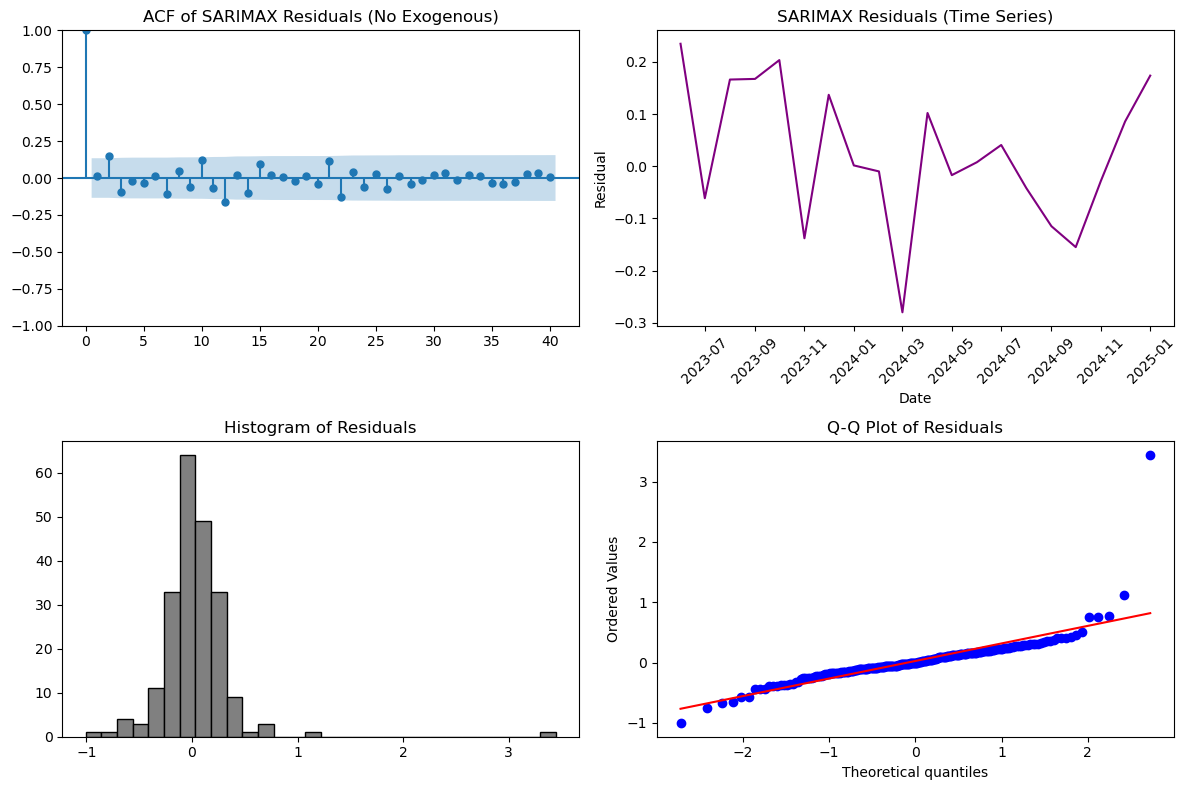

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  14.510000   0.150974
20  26.790299   0.141268
30  37.643805   0.159111


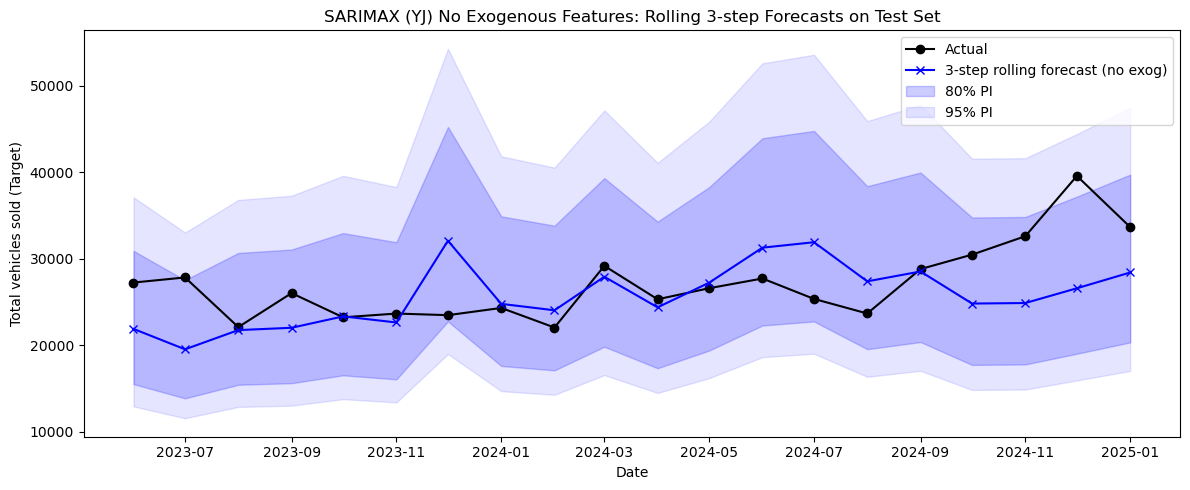

Test RMSE (rolling): 5263.42
Test MAPE (rolling): 13.77%


In [31]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

warnings.filterwarnings("ignore")

# Settings
horizon = 3
lag = 6  # kept for compatibility but no exog features used now

# Combine train + val for fitting initial model
train_val_yj = np.concatenate([y_train_yj.values, y_val_yj.values])
test_yj = y_test_yj.values

n_train_val = len(train_val_yj)
n_test = len(test_yj)

lam = yeojohnson_lambdas_all[target_raw]

def inv_yeojohnson(z, lam):
    if np.isclose(lam, 0):
        return np.exp(z) - 1
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
    return out

preds_level = []
ci80_lower = []
ci80_upper = []
ci95_lower = []
ci95_upper = []

for t in range(n_test - horizon + 1):
    # Combine train+val + partial test history up to t
    y_hist = np.concatenate([train_val_yj, test_yj[:t]])

    # No exogenous variables now, so no exog preparation
    # Fit SARIMAX model without exog
    model = SARIMAX(
        y_hist,
        order=(0, 1, 1), # Let op heb 211 gedaan hier 
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    # Forecast next horizon steps
    fc = fitted.get_forecast(steps=horizon)
    yj_forecast_level = fc.predicted_mean[-1]

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
plot_dates = df["Time Period (T)"].iloc[val_end_yj + horizon - 1:test_end_yj][:len(preds_level)]

# Diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals (No Exogenous)")

axes[0, 1].plot(plot_dates, fitted.resid[-len(plot_dates):], color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat', 'lb_pvalue']])

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast (no exog)')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('SARIMAX (YJ) No Exogenous Features: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)
print(f"Test RMSE (rolling): {rmse:.2f}")
print(f"Test MAPE (rolling): {mape:.2%}")


> Extra Lag test

In [32]:
# import warnings
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.stats.diagnostic import acorr_ljungbox

# warnings.filterwarnings("ignore")

# # Settings
# horizon = 3
# lags_to_test = range(0, 13)  # lags 0 to 12 inclusive

# # Data
# train_yj = y_train_yj.values
# val_yj = y_val_yj.values

# features = {
#     'Gasoline': yj_df['Gasoline (Euro95) - Average price (F)_yj'].values,
#     'Company Car Tax': yj_df['Company car tax rate (%)_yj'].values,
#     'Home Charging': yj_df['Home charging (G)_yj'].values,
#     'Consumer Confidence': yj_df['Consumer confidence (E)_yj'].values
# }

# n_train = len(train_yj)
# n_val = len(val_yj)
# lam = yeojohnson_lambdas_all[target_raw]

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     out[:lag] = np.nan
#     return out

# def inv_yeojohnson(z, lam):
#     import numpy as np
#     if np.isclose(lam, 0):
#         return np.exp(z) - 1
#     elif lam == 2:
#         return -np.exp(-z)
#     out = np.zeros_like(z)
#     pos = z >= 0
#     out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
#     out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
#     return out

# for feat_name, feat_vals in features.items():
#     print(f"\n=== Testing feature: {feat_name} ===")
#     for lag in lags_to_test:
#         preds_level = []

#         for t in range(n_val - horizon + 1):
#             y_hist = np.concatenate([train_yj, val_yj[:t]])
#             idx_offset = n_train + t

#             feat_hist = np.concatenate([feat_vals[:n_train], feat_vals[n_train:n_train + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)

#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]

#             feat_future = feat_vals[:idx_offset + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)

#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(0, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)

#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]

#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#         actuals_level = inv_yeojohnson(val_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         mape = mean_absolute_percentage_error(actuals_level, preds_level)

#         lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)

#         print(f"Lag {lag:2d} | RMSE: {rmse:10.2f} | MAPE: {mape:10.2%} | AIC: {fitted.aic:10.2f} | BIC: {fitted.bic:10.2f}")
#         print("Ljung-Box p-values (lags 10,20,30):", lb['lb_pvalue'].values)

# print("\nTesting complete.")


# # Collect best RMSE and corresponding lag for each feature
# best_results = []
# for feat_name, feat_vals in features.items():
#     min_rmse = float('inf')
#     best_lag = None
#     for lag in lags_to_test:
#         preds_level = []
#         for t in range(n_val - horizon + 1):
#             y_hist = np.concatenate([train_yj, val_yj[:t]])
#             idx_offset = n_train + t
#             feat_hist = np.concatenate([feat_vals[:n_train], feat_vals[n_train:n_train + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)
#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]
#             feat_future = feat_vals[:idx_offset + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)
#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(1, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)
#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]
#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])
#         actuals_level = inv_yeojohnson(val_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         if rmse < min_rmse:
#             min_rmse = rmse
#             best_lag = lag
#     best_results.append((feat_name, min_rmse, best_lag))

# # Sort and print summary
# best_results.sort(key=lambda x: x[1])
# print("\n=== Best RMSE by Feature (sorted) ===")
# for feat_name, min_rmse, best_lag in best_results:
#     print(f"{feat_name:25s} | Best RMSE: {min_rmse:10.2f} | Lag: {best_lag}")


In [33]:
# ### Same thing but on test 

# import warnings
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.stats.diagnostic import acorr_ljungbox

# warnings.filterwarnings("ignore")

# # Settings
# horizon = 3
# lags_to_test = range(0, 13)  # lags 0 to 12 inclusive

# # Data
# train_yj = y_train_yj.values
# val_yj = y_val_yj.values
# test_yj = y_test_yj.values

# features = {
#     'Gasoline': yj_df['Gasoline (Euro95) - Average price (F)_yj'].values,
#     'Company Car Tax': yj_df['Company car tax rate (%)_yj'].values,
#     'Home Charging': yj_df['Home charging (G)_yj'].values,
#     'Consumer Confidence': yj_df['Consumer confidence (E)_yj'].values
# }

# n_train = len(train_yj)
# n_val = len(val_yj)
# n_test = len(test_yj)
# lam = yeojohnson_lambdas_all[target_raw]

# def make_lag(arr, lag):
#     out = np.roll(arr, lag)
#     out[:lag] = np.nan
#     return out

# def inv_yeojohnson(z, lam):
#     import numpy as np
#     if np.isclose(lam, 0):
#         return np.exp(z) - 1
#     elif lam == 2:
#         return -np.exp(-z)
#     out = np.zeros_like(z)
#     pos = z >= 0
#     out[pos] = np.power(z[pos] * lam + 1, 1 / lam) - 1
#     out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1 / (2 - lam))
#     return out

# print("Starting tests on test set using train + val for training...\n")

# for feat_name, feat_vals in features.items():
#     print(f"=== Feature: {feat_name} ===")
#     for lag in lags_to_test:
#         preds_level = []

#         # Combine train + val for history
#         train_val_yj = np.concatenate([train_yj, val_yj])
#         n_train_val = len(train_val_yj)

#         for t in range(n_test - horizon + 1):
#             # History includes train+val + partial test history up to t
#             y_hist = np.concatenate([train_val_yj, test_yj[:t]])

#             feat_hist = np.concatenate([feat_vals[:n_train_val], feat_vals[n_train_val:n_train_val + t]])
#             feat_lag = make_lag(feat_hist, lag).reshape(-1, 1)

#             valid = ~np.isnan(feat_lag).flatten()
#             y_hist_valid = y_hist[valid]
#             feat_lag_valid = feat_lag[valid]

#             feat_future = feat_vals[:n_train_val + t + horizon]
#             feat_future_lag = make_lag(feat_future, lag)[-horizon:].reshape(-1, 1)

#             model = SARIMAX(
#                 y_hist_valid,
#                 exog=feat_lag_valid,
#                 order=(1, 1, 1),
#                 seasonal_order=(1, 0, 0, 12),
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             fitted = model.fit(disp=False)

#             fc = fitted.get_forecast(steps=horizon, exog=feat_future_lag)
#             yj_forecast_level = fc.predicted_mean[-1]

#             preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

#         actuals_level = inv_yeojohnson(test_yj[horizon - 1:], lam)
#         rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
#         mape = mean_absolute_percentage_error(actuals_level, preds_level)

#         lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)

#         print(f"Lag {lag:2d} | RMSE: {rmse:10.2f} | MAPE: {mape:10.2%} | AIC: {fitted.aic:10.2f} | BIC: {fitted.bic:10.2f}")
#         print("Ljung-Box p-values (lags 10,20,30):", lb['lb_pvalue'].values)
#     print("\n")

# print("Testing complete.")
